## Imports

In [181]:
# Imports
import sys, os, signal, time
from scipy import signal
from ai_economist import foundation
from ai_economist.foundation.base.base_env import BaseEnvironment, scenario_registry
from ai_economist.foundation.scenarios.utils import rewards, social_metrics
from copy import deepcopy
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
from utils import plotting

## Environment Class

This is a modified version of the environment class used in one of the AI Economist tutorials. I modified this environment class to see how the agents will perform under different conditions. 

## coin_eq_times_productivity Environment

In [182]:
@scenario_registry.add
class Uniform(BaseEnvironment):
    """
    World containing spatially-segregated stone and wood with stochastic regeneration.

    For controlling how resource regeneration behavior...
        Coverage: if fraction, target fraction of total tiles; if integer, target number
            of tiles
        Regen Halfwidth: width of regen kernel = 1 + (2 * halfwidth); set >0 to create
            a spatial social dilemma
        Regen Weight: regen probability per tile counted by the regen kernel
        Max Health: how many resource units can populate a source block
        Clumpiness: degree to which resources are spatially clustered
        Gradient Steepness: degree to which stone/wood are restricted to the top/bottom
            of the map

    Args:
        planner_gets_spatial_obs (bool): Whether the planner agent receives spatial
            observations from the world.
        full_observability (bool): Whether the mobile agents' spatial observation
            includes the full world view or is instead an egocentric view.
        mobile_agent_observation_range (int): If not using full_observability,
            the spatial range (on each side of the agent) that is visible in the
            spatial observations.
        starting_wood_coverage (int, float): Target coverage of wood at t=0.
        wood_regen_halfwidth (int): Regen halfwidth for wood.
        wood_regen_weight (float): Regen weight for wood.
        wood_max_health (int): Max wood units per wood source tile.
        wood_clumpiness (float): Degree of wood clumping.
        starting_stone_coverage (int, float): Target coverage of stone at t=0.
        stone_regen_halfwidth (int): Regen halfwidth for stone.
        stone_regen_weight (float): Regen weight for stone.
        stone_max_health (int): Max stone units per stone source tile.
        stone_clumpiness (float): Degree of stone clumping.
        gradient_steepness (int, float): How steeply source tile probability falls
            off from the top/bottom of the map.
        checker_source_blocks (bool): Whether to space source tiles in a "checker"
            formation.
        starting_agent_coin (int, float): Amount of coin agents have at t=0. Defaults
            to zero coin.
        isoelastic_eta (float): Parameter controlling the shape of agent utility
            wrt coin endowment.
        energy_cost (float): Coefficient for converting labor to negative utility.
        energy_warmup_constant (float): Decay constant that controls the rate at which
            the effective energy cost is annealed from 0 to energy_cost. Set to 0
            (default) to disable annealing, meaning that the effective energy cost is
            always energy_cost. The units of the decay constant depend on the choice of
            energy_warmup_method.
        energy_warmup_method (str): How to schedule energy annealing (warmup). If
            "decay" (default), use the number of completed episodes. If "auto",
            use the number of timesteps where the average agent reward was positive.
        planner_reward_type (str): The type of reward used for the planner. Options
            are "coin_eq_times_productivity" (default),
            "inv_income_weighted_coin_endowment", and "inv_income_weighted_utility".
        mixing_weight_gini_vs_coin (float): Degree to which equality is ignored w/
            "coin_eq_times_productivity". Default is 0, which weights equality and
            productivity equally. If set to 1, only productivity is rewarded.

    """

    name = "mlc_environment_coin_eq_times_productivity"
    agent_subclasses = ["BasicMobileAgent", "BasicPlanner"]
    required_entities = ["Wood", "Stone"]

    def __init__(
        self,
        *base_env_args,
        planner_gets_spatial_info=True,
        full_observability=False,
        mobile_agent_observation_range=5,
        starting_wood_coverage=0.025,
        wood_regen_halfwidth=0,
        wood_regen_weight=0.01,
        wood_max_health=1,
        starting_stone_coverage=0.025,
        stone_regen_halfwidth=0,
        stone_regen_weight=0.01,
        stone_max_health=1,
        wood_clumpiness=0.35,
        stone_clumpiness=0.5,
        gradient_steepness=8,
        checker_source_blocks=False,
        starting_agent_coin=0,
        isoelastic_eta=0.23,
        energy_cost=0.21,
        energy_warmup_constant=0,
        energy_warmup_method="decay",
        planner_reward_type="coin_eq_times_productivity",
        mixing_weight_gini_vs_coin=0.0,
        **base_env_kwargs
    ):
        super().__init__(*base_env_args, **base_env_kwargs)

        # Whether agents receive spatial information in their observation tensor
        self._planner_gets_spatial_info = bool(planner_gets_spatial_info)

        # Whether the (non-planner) agents can see the whole world map
        self._full_observability = bool(full_observability)

        self._mobile_agent_observation_range = int(mobile_agent_observation_range)

        # For controlling how resource regeneration behavior
        #  - Coverage: if fraction, target fraction of total tiles;
        #  if integer, target number of tiles
        #  - Regen Halfwidth: width of regen kernel = 1 + (2 * halfwidth)
        #  - Regen Weight: regen probability per tile counted by the regen kernel
        #  - Max Health: how many resource units can populate a source block
        #  - Clumpiness: degree to which resources are spatially clustered
        #  - Gradient Steepness: degree to which stone/wood
        #  are restricted to top/bottom of map
        self.layout_specs = dict(Wood={}, Stone={})
        #
        if starting_wood_coverage >= 1:
            starting_wood_coverage /= np.prod(self.world_size)
        if starting_stone_coverage >= 1:
            starting_stone_coverage /= np.prod(self.world_size)
        assert (starting_stone_coverage + starting_wood_coverage) < 0.5
        #
        self._checker_source_blocks = bool(checker_source_blocks)
        c, r = np.meshgrid(
            np.arange(self.world_size[1]) % 2, np.arange(self.world_size[0]) % 2
        )
        self._checker_mask = (r + c) == 1
        m = 2 if self._checker_source_blocks else 1
        #
        self.layout_specs["Wood"]["starting_coverage"] = (
            float(starting_wood_coverage) * m
        )
        self.layout_specs["Stone"]["starting_coverage"] = (
            float(starting_stone_coverage) * m
        )
        assert 0 < self.layout_specs["Wood"]["starting_coverage"] < 1
        assert 0 < self.layout_specs["Stone"]["starting_coverage"] < 1
        #
        self.layout_specs["Wood"]["regen_halfwidth"] = int(wood_regen_halfwidth)
        self.layout_specs["Stone"]["regen_halfwidth"] = int(stone_regen_halfwidth)
        assert 0 <= self.layout_specs["Wood"]["regen_halfwidth"] <= 3
        assert 0 <= self.layout_specs["Stone"]["regen_halfwidth"] <= 3
        #
        self.layout_specs["Wood"]["regen_weight"] = float(wood_regen_weight)
        self.layout_specs["Stone"]["regen_weight"] = float(stone_regen_weight)
        assert 0 <= self.layout_specs["Wood"]["regen_weight"] <= 1
        assert 0 <= self.layout_specs["Stone"]["regen_weight"] <= 1
        #
        self.layout_specs["Wood"]["max_health"] = int(wood_max_health)
        self.layout_specs["Stone"]["max_health"] = int(stone_max_health)
        assert self.layout_specs["Wood"]["max_health"] > 0
        assert self.layout_specs["Stone"]["max_health"] > 0
        #
        self.clumpiness = {
            "Wood": float(wood_clumpiness),
            "Stone": float(stone_clumpiness),
        }
        assert all(0 <= v <= 1 for v in self.clumpiness.values())
        #
        self.gradient_steepness = float(gradient_steepness)
        assert self.gradient_steepness >= 1.0
        #
        self.source_prob_maps = self.make_source_prob_maps()
        self.source_maps = {
            k: np.zeros_like(v) for k, v in self.source_prob_maps.items()
        }

        # How much coin do agents begin with at upon reset
        self.starting_agent_coin = float(starting_agent_coin)
        assert self.starting_agent_coin >= 0.0

        # Controls the diminishing marginal utility of coin.
        # isoelastic_eta=0 means no diminishing utility.
        self.isoelastic_eta = float(isoelastic_eta)
        assert 0.0 <= self.isoelastic_eta <= 1.0

        # The amount that labor is weighted in utility computation
        # (once annealing is finished)
        self.energy_cost = float(energy_cost)
        assert self.energy_cost >= 0

        # What value to use for calculating the progress of energy annealing
        # If method = 'decay': #completed episodes
        # If method = 'auto' : #timesteps where avg. agent reward > 0
        self.energy_warmup_method = energy_warmup_method.lower()
        assert self.energy_warmup_method in ["decay", "auto"]
        # Decay constant for annealing to full energy cost
        # (if energy_warmup_constant == 0, there is no annealing)
        self.energy_warmup_constant = float(energy_warmup_constant)
        assert self.energy_warmup_constant >= 0
        self._auto_warmup_integrator = 0

        # Which social welfare function to use
        self.planner_reward_type = str(planner_reward_type).lower()

        # How much to weight equality if using SWF=eq*prod:
        # 0 -> SWF=eq*prod
        # 1 -> SWF=prod
        self.mixing_weight_gini_vs_coin = float(mixing_weight_gini_vs_coin)
        assert 0 <= self.mixing_weight_gini_vs_coin <= 1.0

        # Use this to calculate marginal changes and deliver that as reward
        self.init_optimization_metric = {agent.idx: 0 for agent in self.all_agents}
        self.prev_optimization_metric = {agent.idx: 0 for agent in self.all_agents}
        self.curr_optimization_metric = {agent.idx: 0 for agent in self.all_agents}

    @property
    def energy_weight(self):
        """
        Energy annealing progress. Multiply with self.energy_cost to get the
        effective energy coefficient.
        """
        if self.energy_warmup_constant <= 0.0:
            return 1.0

        if self.energy_warmup_method == "decay":
            return float(1.0 - np.exp(-self._completions / self.energy_warmup_constant))

        if self.energy_warmup_method == "auto":
            return float(
                1.0
                - np.exp(-self._auto_warmup_integrator / self.energy_warmup_constant)
            )

        raise NotImplementedError

    def get_current_optimization_metrics(self):
        """
        Compute optimization metrics based on the current state. Used to compute reward.

        Returns:
            curr_optimization_metric (dict): A dictionary of {agent.idx: metric}
                with an entry for each agent (including the planner) in the env.
        """
        curr_optimization_metric = {}
        # (for agents)
        for agent in self.world.agents:
            curr_optimization_metric[agent.idx] = rewards.isoelastic_coin_minus_labor(
                coin_endowment=agent.total_endowment("Coin"),
                total_labor=agent.state["endogenous"]["Labor"],
                isoelastic_eta=self.isoelastic_eta,
                labor_coefficient=self.energy_weight * self.energy_cost,
            )
        # (for the planner)
        if self.planner_reward_type == "coin_eq_times_productivity":
            curr_optimization_metric[
                self.world.planner.idx
            ] = rewards.coin_eq_times_productivity(
                coin_endowments=np.array(
                    [agent.total_endowment("Coin") for agent in self.world.agents]
                ),
                equality_weight=1 - self.mixing_weight_gini_vs_coin,
            )
        elif self.planner_reward_type == "inv_income_weighted_coin_endowments":
            curr_optimization_metric[
                self.world.planner.idx
            ] = rewards.inv_income_weighted_coin_endowments(
                coin_endowments=np.array(
                    [agent.total_endowment("Coin") for agent in self.world.agents]
                )
            )
        elif self.planner_reward_type == "inv_income_weighted_utility":
            curr_optimization_metric[
                self.world.planner.idx
            ] = rewards.inv_income_weighted_utility(
                coin_endowments=np.array(
                    [agent.total_endowment("Coin") for agent in self.world.agents]
                ),
                utilities=np.array(
                    [curr_optimization_metric[agent.idx] for agent in self.world.agents]
                ),
            )
        else:
            print("No valid planner reward selected!")
            raise NotImplementedError
        return curr_optimization_metric

    def make_source_prob_maps(self):
        """
        Make maps specifying how likely each location is to be assigned as a resource
        source tile.

        Returns:
            source_prob_maps (dict): Contains a source probability map for both
                stone and wood
        """
        prob_gradient = (
            np.arange(self.world_size[0])[:, None].repeat(self.world_size[1], axis=1)
            ** self.gradient_steepness
        )
        prob_gradient = prob_gradient / np.mean(prob_gradient)

        return {
            "Wood": prob_gradient * self.layout_specs["Wood"]["starting_coverage"],
            "Stone": prob_gradient[-1::-1]
            * self.layout_specs["Wood"]["starting_coverage"],
        }

    # The following methods must be implemented for each scenario
    # -----------------------------------------------------------

    def reset_starting_layout(self):
        """
        Part 1/2 of scenario reset. This method handles resetting the state of the
        environment managed by the scenario (i.e. resource & landmark layout).

        Here, generate a resource source layout consistent with target parameters.
        """
        happy_coverage = False
        n_reset_tries = 0

        # Attempt to do a reset until an attempt limit is reached or coverage is good
        while n_reset_tries < 100 and not happy_coverage:
            self.world.maps.clear()

            self.source_maps = {
                k: np.zeros_like(v) for k, v in self.source_prob_maps.items()
            }

            resources = ["Wood", "Stone"]

            for resource in resources:
                clump = 1 - np.clip(self.clumpiness[resource], 0.0, 0.99)

                source_prob = self.source_prob_maps[resource] * 0.1 * clump

                empty = self.world.maps.empty

                tmp = np.random.rand(*source_prob.shape)
                maybe_source_map = (tmp < source_prob) * empty

                n_tries = 0
                while np.mean(maybe_source_map) < (
                    self.layout_specs[resource]["starting_coverage"] * clump
                ):
                    tmp *= 0.9
                    maybe_source_map = (tmp < source_prob) * empty
                    n_tries += 1
                    if n_tries > 200:
                        break

                while (
                    np.mean(maybe_source_map)
                    < self.layout_specs[resource]["starting_coverage"]
                ):
                    kernel = np.random.randn(7, 7) > 0
                    tmp = signal.convolve2d(
                        maybe_source_map
                        + (0.2 * np.random.randn(*maybe_source_map.shape))
                        - 0.25,
                        kernel.astype(np.float32),
                        "same",
                    )
                    maybe_source_map = np.maximum(tmp > 0, maybe_source_map) * empty

                self.source_maps[resource] = maybe_source_map
                self.world.maps.set(
                    resource, maybe_source_map
                )  # * self.layout_specs[resource]['max_health'])
                self.world.maps.set(resource + "SourceBlock", maybe_source_map)

            # Restart if the resource distribution is too far off the target coverage
            happy_coverage = True
            for resource in resources:
                coverage_quotient = (
                    np.mean(self.source_maps[resource])
                    / self.layout_specs[resource]["starting_coverage"]
                )
                bound = 0.4
                if not (1 / (1 + bound)) <= coverage_quotient <= (1 + bound):
                    happy_coverage = False

            n_reset_tries += 1

        # Apply checkering, if applicable
        if self._checker_source_blocks:
            for resource, source_map in self.source_maps.items():
                source_map = source_map * self._checker_mask
                self.source_maps[resource] = source_map
                self.world.maps.set(resource, source_map)
                self.world.maps.set(resource + "SourceBlock", source_map)

    def reset_agent_states(self):
        """
        Part 2/2 of scenario reset. This method handles resetting the state of the
        agents themselves (i.e. inventory, locations, etc.).

        Here, empty inventories, give mobile agents any starting coin, and place them
        in random accessible locations to start.
        """
        self.world.clear_agent_locs()

        for agent in self.world.agents:
            # Clear everything to start with
            agent.state["inventory"] = {k: 0 for k in agent.inventory.keys()}
            agent.state["escrow"] = {k: 0 for k in agent.inventory.keys()}
            agent.state["endogenous"] = {k: 0 for k in agent.endogenous.keys()}
            # Add starting coin
            agent.state["inventory"]["Coin"] = float(self.starting_agent_coin)

        # Clear everything for the planner
        self.world.planner.state["inventory"] = {
            k: 0 for k in self.world.planner.inventory.keys()
        }
        self.world.planner.state["escrow"] = {
            k: 0 for k in self.world.planner.escrow.keys()
        }

        # Place the agents randomly in the world
        for agent in self.world.get_random_order_agents():
            r = np.random.randint(0, self.world_size[0])
            c = np.random.randint(0, self.world_size[1])
            n_tries = 0
            while not self.world.can_agent_occupy(r, c, agent):
                r = np.random.randint(0, self.world_size[0])
                c = np.random.randint(0, self.world_size[1])
                n_tries += 1
                if n_tries > 200:
                    raise TimeoutError
            self.world.set_agent_loc(agent, r, c)

    def scenario_step(self):
        """
        Update the state of the world according to whatever rules this scenario
        implements.

        This gets called in the 'step' method (of base_env) after going through each
        component step and before generating observations, rewards, etc.

        In this class of scenarios, the scenario step handles stochastic resource
        regeneration.
        """

        resources = ["Wood", "Stone"]

        for resource in resources:
            d = 1 + (2 * self.layout_specs[resource]["regen_halfwidth"])
            kernel = (
                self.layout_specs[resource]["regen_weight"] * np.ones((d, d)) / (d ** 2)
            )

            resource_map = self.world.maps.get(resource)
            resource_source_blocks = self.world.maps.get(resource + "SourceBlock")
            spawnable = (
                self.world.maps.empty + resource_map + resource_source_blocks
            ) > 0
            spawnable *= resource_source_blocks > 0

            health = np.maximum(resource_map, resource_source_blocks)
            respawn = np.random.rand(*health.shape) < signal.convolve2d(
                health, kernel, "same"
            )
            respawn *= spawnable

            self.world.maps.set(
                resource,
                np.minimum(
                    resource_map + respawn, self.layout_specs[resource]["max_health"]
                ),
            )

    def generate_observations(self):
        """
        Generate observations associated with this scenario.

        A scenario does not need to produce observations and can provide observations
        for only some agent types; however, for a given agent type, it should either
        always or never yield an observation. If it does yield an observation,
        that observation should always have the same structure/sizes!

        Returns:
            obs (dict): A dictionary of {agent.idx: agent_obs_dict}. In words,
                return a dictionary with an entry for each agent (which can including
                the planner) for which this scenario provides an observation. For each
                entry, the key specifies the index of the agent and the value contains
                its associated observation dictionary.

        Here, non-planner agents receive spatial observations (depending on the env
        config) as well as the contents of their inventory and endogenous quantities.
        The planner also receives spatial observations (again, depending on the env
        config) as well as the inventory of each of the mobile agents.
        """
        obs = {}
        curr_map = self.world.maps.state

        owner_map = self.world.maps.owner_state
        loc_map = self.world.loc_map
        agent_idx_maps = np.concatenate([owner_map, loc_map[None, :, :]], axis=0)
        agent_idx_maps += 2
        agent_idx_maps[agent_idx_maps == 1] = 0

        agent_locs = {
            str(agent.idx): {
                "loc-row": agent.loc[0] / self.world_size[0],
                "loc-col": agent.loc[1] / self.world_size[1],
            }
            for agent in self.world.agents
        }
        agent_invs = {
            str(agent.idx): {
                "inventory-" + k: v * self.inv_scale for k, v in agent.inventory.items()
            }
            for agent in self.world.agents
        }

        obs[self.world.planner.idx] = {
            "inventory-" + k: v * self.inv_scale
            for k, v in self.world.planner.inventory.items()
        }
        if self._planner_gets_spatial_info:
            obs[self.world.planner.idx].update(
                dict(map=curr_map, idx_map=agent_idx_maps)
            )

        # Mobile agents see the full map. Convey location info via one-hot map channels.
        if self._full_observability:
            for agent in self.world.agents:
                my_map = np.array(agent_idx_maps)
                my_map[my_map == int(agent.idx) + 2] = 1
                sidx = str(agent.idx)
                obs[sidx] = {"map": curr_map, "idx_map": my_map}
                obs[sidx].update(agent_invs[sidx])

        # Mobile agents only see within a window around their position
        else:
            w = (
                self._mobile_agent_observation_range
            )  # View halfwidth (only applicable without full observability)

            padded_map = np.pad(
                curr_map,
                [(0, 1), (w, w), (w, w)],
                mode="constant",
                constant_values=[(0, 1), (0, 0), (0, 0)],
            )

            padded_idx = np.pad(
                agent_idx_maps,
                [(0, 0), (w, w), (w, w)],
                mode="constant",
                constant_values=[(0, 0), (0, 0), (0, 0)],
            )

            for agent in self.world.agents:
                r, c = [c + w for c in agent.loc]
                visible_map = padded_map[
                    :, (r - w) : (r + w + 1), (c - w) : (c + w + 1)
                ]
                visible_idx = np.array(
                    padded_idx[:, (r - w) : (r + w + 1), (c - w) : (c + w + 1)]
                )

                visible_idx[visible_idx == int(agent.idx) + 2] = 1

                sidx = str(agent.idx)

                obs[sidx] = {"map": visible_map, "idx_map": visible_idx}
                obs[sidx].update(agent_locs[sidx])
                obs[sidx].update(agent_invs[sidx])

                # Agent-wise planner info (gets crunched into the planner obs in the
                # base scenario code)
                obs["p" + sidx] = agent_invs[sidx]
                if self._planner_gets_spatial_info:
                    obs["p" + sidx].update(agent_locs[sidx])

        return obs

    def compute_reward(self):
        """
        Apply the reward function(s) associated with this scenario to get the rewards
        from this step.

        Returns:
            rew (dict): A dictionary of {agent.idx: agent_obs_dict}. In words,
                return a dictionary with an entry for each agent in the environment
                (including the planner). For each entry, the key specifies the index of
                the agent and the value contains the scalar reward earned this timestep.

        Rewards are computed as the marginal utility (agents) or marginal social
        welfare (planner) experienced on this timestep. Ignoring discounting,
        this means that agents' (planner's) objective is to maximize the utility
        (social welfare) associated with the terminal state of the episode.
        """

        # "curr_optimization_metric" hasn't been updated yet, so it gives us the
        # utility from the last step.
        utility_at_end_of_last_time_step = deepcopy(self.curr_optimization_metric)

        # compute current objectives and store the values
        self.curr_optimization_metric = self.get_current_optimization_metrics()

        # reward = curr - prev objectives
        rew = {
            k: float(v - utility_at_end_of_last_time_step[k])
            for k, v in self.curr_optimization_metric.items()
        }

        # store the previous objective values
        self.prev_optimization_metric.update(utility_at_end_of_last_time_step)

        # Automatic Energy Cost Annealing
        # -------------------------------
        avg_agent_rew = np.mean([rew[a.idx] for a in self.world.agents])
        # Count the number of timesteps where the avg agent reward was > 0
        if avg_agent_rew > 0:
            self._auto_warmup_integrator += 1

        return rew

    # Optional methods for customization
    # ----------------------------------

    def additional_reset_steps(self):
        """
        Extra scenario-specific steps that should be performed at the end of the reset
        cycle.

        For each reset cycle...
            First, reset_starting_layout() and reset_agent_states() will be called.

            Second, <component>.reset() will be called for each registered component.

            Lastly, this method will be called to allow for any final customization of
            the reset cycle.

        For this scenario, this method resets optimization metric trackers.
        """
        # compute current objectives
        curr_optimization_metric = self.get_current_optimization_metrics()

        self.curr_optimization_metric = deepcopy(curr_optimization_metric)
        self.init_optimization_metric = deepcopy(curr_optimization_metric)
        self.prev_optimization_metric = deepcopy(curr_optimization_metric)

    def scenario_metrics(self):
        """
        Allows the scenario to generate metrics (collected along with component metrics
        in the 'metrics' property).

        To have the scenario add metrics, this function needs to return a dictionary of
        {metric_key: value} where 'value' is a scalar (no nesting or lists!)

        Here, summarize social metrics, endowments, utilities, and labor cost annealing
        """
        metrics = dict()

        coin_endowments = np.array(
            [agent.total_endowment("Coin") for agent in self.world.agents]
        )
        metrics["social/productivity"] = social_metrics.get_productivity(
            coin_endowments
        )
        metrics["social/equality"] = social_metrics.get_equality(coin_endowments)

        utilities = np.array(
            [self.curr_optimization_metric[agent.idx] for agent in self.world.agents]
        )
        metrics[
            "social_welfare/coin_eq_times_productivity"
        ] = rewards.coin_eq_times_productivity(
            coin_endowments=coin_endowments, equality_weight=1.0
        )
        metrics[
            "social_welfare/inv_income_weighted_coin_endow"
        ] = rewards.inv_income_weighted_coin_endowments(coin_endowments=coin_endowments)
        metrics[
            "social_welfare/inv_income_weighted_utility"
        ] = rewards.inv_income_weighted_utility(
            coin_endowments=coin_endowments, utilities=utilities
        )

        for agent in self.all_agents:
            for resource, quantity in agent.inventory.items():
                metrics[
                    "endow/{}/{}".format(agent.idx, resource)
                ] = agent.total_endowment(resource)

            if agent.endogenous is not None:
                for resource, quantity in agent.endogenous.items():
                    metrics["endogenous/{}/{}".format(agent.idx, resource)] = quantity

            metrics["util/{}".format(agent.idx)] = self.curr_optimization_metric[
                agent.idx
            ]

        # Labor weight
        metrics["labor/weighted_cost"] = self.energy_cost * self.energy_weight
        metrics["labor/warmup_integrator"] = int(self._auto_warmup_integrator)

        return metrics


@scenario_registry.add
class MultiZone(Uniform):
    """
    World containing stone and wood clustered in "zones" with stochastic regeneration.

    For controlling how resource regeneration behavior...
        Regen Halfwidth: width of regen kernel = 1 + (2 * halfwidth); set >0 to create
            spatial social dilemma
        Regen Weight: regen probability per tile counted by the regen kernel
        Max Health: how many resource units can populate a source block

    Args:
        num_partitions_row (int): Number of height-wise partitions (controls #zones).
        num_partitions_col (int): Number of width-wise partitions (controls #zones).
        num_wood_zones (int): Number of zones where wood will appear.
        num_stone_zones (int): Number of zones where stone will appear.
        num_wood_and_stone_zones (int): Number of zones where both wood and stone will
            appear.
        planner_gets_spatial_obs (bool): Whether the planner agent receives spatial
            observations from the world.
        full_observability (bool): Whether the mobile agents' spatial observation
            includes the full world view or is instead an egocentric view.
        mobile_agent_observation_range (int): If not using full_observability,
            the spatial range (on each side of the agent) that is visible in the
            spatial observations.
        wood_regen_halfwidth (int): Regen halfwidth for wood.
        wood_regen_weight (float): Regen weight for wood.
        wood_max_health (int): Max wood units per wood source tile.
        stone_regen_halfwidth (int): Regen halfwidth for stone.
        stone_regen_weight (float): Regen weight for stone.
        stone_max_health (int): Max stone units per stone source tile.
        starting_agent_coin (int, float): Amount of coin agents have at t=0.
        isoelastic_eta (float): Parameter controlling the shape of agent utility
            wrt coin endowment.
        energy_cost (float): Coefficient for converting labor to negative utility.
        energy_warmup_constant (float): Decay constant that controls the rate at which
            the effective energy cost is annealed from 0 to energy_cost. Set to 0
            (default) to disable annealing, meaning that the effective energy cost is
            always energy_cost. The units of the decay constant depend on the choice of
            energy_warmup_method.
        energy_warmup_method (str): How to schedule energy annealing (warmup). If
            "decay" (default), use the number of completed episodes. If "auto",
            use the number of timesteps where the average agent reward was positive.
        planner_reward_type (str): The type of reward used for the planner. Options
            are "coin_eq_times_productivity" (default),
            "inv_income_weighted_coin_endowment", and "inv_income_weighted_utility".
        mixing_weight_gini_vs_coin (float): Degree to which equality is ignored w/
            "coin_eq_times_productivity". Default is 0, which weights equality and
            productivity equally. If set to 1, only productivity is rewarded.
    """

    name = "multi_zone/simple_wood_and_stone"

    def __init__(
        self,
        *args,
        num_partitions_row=8,
        num_partitions_col=8,
        num_wood_zones=6,
        num_stone_zones=6,
        num_wood_and_stone_zones=4,
        **kwargs
    ):
        self.num_partitions_row = num_partitions_row
        self.num_partitions_col = num_partitions_col
        self.zone_specs = {
            "Wood": (0, num_wood_zones),
            "Stone": (1, num_stone_zones),
            "WoodStone": (2, num_wood_and_stone_zones),
        }

        super().__init__(*args, **kwargs)

    def make_source_prob_maps(self):
        """
        Make maps specifying how likely each location is to be assigned as a resource
        source tile.

        Returns:
            source_prob_maps (dict): Contains a source probability map for both
                stone and wood.
        """
        # determines initial world probability masses
        zone_names = list(self.zone_specs.keys())
        zone_indices = [v[0] for _, v in self.zone_specs.items()]
        num_zones_per_type = [self.zone_specs[k][1] for k in zone_names]
        num_zones = sum(num_zones_per_type)

        num_partitions_row = self.num_partitions_row
        num_partitions_col = self.num_partitions_col
        num_regions = num_partitions_row * num_partitions_col

        assert num_regions >= num_zones

        # define regions and starting resource-zone-type
        # (wood, stone, mixed) for each region

        # note: row, col index over regions
        partition_size_row = int(np.ceil(self.world_size[0] / num_partitions_row))
        partition_size_col = int(np.ceil(self.world_size[1] / num_partitions_col))

        # serialize regions in the world and give them an index.
        # -1 means no source blocks in that region
        grid_zone_indices = np.concatenate(
            [
                np.repeat(zone_indices, num_zones_per_type),
                np.array([-1] * (num_regions - num_zones)),
            ]
        )
        np.random.shuffle(grid_zone_indices)
        grid_zone_indices = grid_zone_indices.reshape(
            (num_partitions_row, num_partitions_col)
        )

        wood_prob = np.where(
            np.logical_or(
                np.equal(grid_zone_indices, self.zone_specs["Wood"][0]),
                np.equal(grid_zone_indices, self.zone_specs["WoodStone"][0]),
            ),
            np.ones_like(grid_zone_indices),
            np.zeros_like(grid_zone_indices),
        )
        wood_prob = np.kron(
            wood_prob, np.ones((partition_size_row, partition_size_col))
        )
        wood_prob = wood_prob[: self.world_size[0], : self.world_size[1]]
        wood_prob = wood_prob / np.mean(wood_prob)

        try:
            assert wood_prob.shape[0] == self.world_size[0]
            assert wood_prob.shape[1] == self.world_size[1]
        except AssertionError:
            print("World not correct size!")
            raise

        stone_prob = np.where(
            np.logical_or(
                np.equal(grid_zone_indices, self.zone_specs["Stone"][0]),
                np.equal(grid_zone_indices, self.zone_specs["WoodStone"][0]),
            ),
            np.ones_like(grid_zone_indices),
            np.zeros_like(grid_zone_indices),
        )
        stone_prob = np.kron(
            stone_prob, np.ones((partition_size_row, partition_size_col))
        )
        stone_prob = stone_prob[: self.world_size[0], : self.world_size[1]]
        stone_prob = stone_prob / np.mean(stone_prob)

        try:
            assert stone_prob.shape[0] == self.world_size[0]
            assert stone_prob.shape[1] == self.world_size[1]
        except AssertionError:
            print("World not correct size!")
            raise

        return {
            "Wood": wood_prob * self.layout_specs["Wood"]["starting_coverage"],
            "Stone": stone_prob * self.layout_specs["Wood"]["starting_coverage"],
        }

    def reset_starting_layout(self):
        """
        Reset the starting layout of the world. Modifies parent scenario method such
        that, before doing the reset, it first remakes the source prob maps.
        """
        self.source_prob_maps = self.make_source_prob_maps()
        super().reset_starting_layout()


@scenario_registry.add
class Quadrant(Uniform):
    """
    World containing wood and stone, with water creating 4 nearly closed-off quadrants.
    Wood is concentrated along the left of the map, stone along the top, creating
    different resource concentrations within each of the quadrants.

    For controlling how resource regeneration behavior...
        Coverage: if fraction, target fraction of total tiles; if integer, target number
            of tiles
        Regen Halfwidth: width of regen kernel = 1 + (2 * halfwidth); set >0 to create
            a spatial social dilemma
        Regen Weight: regen probability per tile counted by the regen kernel
        Max Health: how many resource units can populate a source block
        Clumpiness: degree to which resources are spatially clustered
        Gradient Steepness: degree to which stone/wood are restricted to the top/bottom
            of the map

    Args:
        planner_gets_spatial_obs (bool): Whether the planner agent receives spatial
            observations from the world.
        full_observability (bool): Whether the mobile agents' spatial observation
            includes the full world view or is instead an egocentric view.
        mobile_agent_observation_range (int): If not using full_observability,
            the spatial range (on each side of the agent) that is visible in the
            spatial observations.
        starting_wood_coverage (int, float): Target coverage of wood at t=0.
        wood_regen_halfwidth (int): Regen halfwidth for wood.
        wood_regen_weight (float): Regen weight for wood.
        wood_max_health (int): Max wood units per wood source tile.
        wood_clumpiness (float): Degree of wood clumping.
        starting_stone_coverage (int, float): Target coverage of stone at t=0.
        stone_regen_halfwidth (int): Regen halfwidth for stone.
        stone_regen_weight (float): Regen weight for stone.
        stone_max_health (int): Max stone units per stone source tile.
        stone_clumpiness (float): Degree of stone clumping.
        gradient_steepness (int, float): How steeply source tile probability falls
            off from the top/bottom of the map.
        checker_source_blocks (bool): Whether to space source tiles in a "checker"
            formation.
        starting_agent_coin (int, float): Amount of coin agents have at t=0.
        isoelastic_eta (float): Parameter controlling the shape of agent utility
            wrt coin endowment.
        energy_cost (float): Coefficient for converting labor to negative utility.
        energy_warmup_constant (float): Decay constant that controls the rate at which
            the effective energy cost is annealed from 0 to energy_cost. Set to 0
            (default) to disable annealing, meaning that the effective energy cost is
            always energy_cost. The units of the decay constant depend on the choice of
            energy_warmup_method.
        energy_warmup_method (str): How to schedule energy annealing (warmup). If
            "decay" (default), use the number of completed episodes. If "auto",
            use the number of timesteps where the average agent reward was positive.
        planner_reward_type (str): The type of reward used for the planner. Options
            are "coin_eq_times_productivity" (default),
            "inv_income_weighted_coin_endowment", and "inv_income_weighted_utility".
        mixing_weight_gini_vs_coin (float): Degree to which equality is ignored w/
            "coin_eq_times_productivity". Default is 0, which weights equality and
            productivity equally. If set to 1, only productivity is rewarded.

    """

    name = "quadrant/simple_wood_and_stone"
    required_entities = Uniform.required_entities + ["Water"]

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        width = self.world_size[1]
        height = self.world_size[0]

        o0 = 0.2
        o1 = 0.35
        rN = (0.5 + np.arange(height)) / height
        cN = (0.5 + np.arange(width)) / width
        rSeg = ((rN < o0) + (rN > o1)) * ((rN < 1 - o1) + (rN > 1 - o0))
        cSeg = ((cN < o0) + (cN > o1)) * ((cN < 1 - o1) + (cN > 1 - o0))
        water = np.zeros((height, width))
        water[:, height // 2] = rSeg
        water[width // 2, :] = cSeg
        self._water = water

        for k, v in self.source_prob_maps.items():
            v = v * (1 - self._water)
            v = v / np.sum(v)
            self.source_prob_maps[k] = v

    def make_source_prob_maps(self):
        """
        Make maps specifying how likely each location is to be assigned as a resource
        source tile.

        Returns:
            source_prob_maps (dict): Contains a source probability map for both
                stone and wood
        """
        width = self.world_size[1]
        height = self.world_size[0]

        prob_gradient = np.arange(height)[:, None].repeat(width, axis=1) ** (
            self.gradient_steepness / 2
        )
        w_prob_gradient = prob_gradient[::-1]

        prob_gradient = np.arange(width)[None].repeat(height, axis=0) ** (
            self.gradient_steepness / 2
        )
        s_prob_gradient = prob_gradient[:, ::-1]

        prob_sum = s_prob_gradient + w_prob_gradient

        s_prob_gradient = prob_sum * s_prob_gradient
        w_prob_gradient = prob_sum * w_prob_gradient

        s_prob_gradient = s_prob_gradient / np.sum(s_prob_gradient)
        w_prob_gradient = w_prob_gradient / np.sum(w_prob_gradient)

        return {"Stone": s_prob_gradient, "Wood": w_prob_gradient}

    def reset_starting_layout(self):
        """
        Reset the starting layout of the world. Modifies parent scenario method to
        add water and remove resources from water locations.
        """

        # Generate the starting layout like normal
        super().reset_starting_layout()

        width = self.world_size[1]
        height = self.world_size[0]

        # Remove anything at the water line
        for entity, state in self.world.maps.items():
            if isinstance(state, dict):
                state["health"][:, height // 2] = 0
                state["health"][width // 2, :] = 0
                state["owner"][:, height // 2] = -1
                state["owner"][width // 2, :] = -1
            else:
                state[:, height // 2] = 0
                state[width // 2, :] = 0
            self.world.maps.set(entity, state)
        for entity, state in self.source_maps.items():
            state[:, height // 2] = 0
            state[width // 2, :] = 0
            self.source_maps[entity] = state

        # Place water
        self.world.maps.set("Water", self._water)


In [183]:
env_config = {
    # ===== STANDARD ARGUMENTS ======
    'n_agents': 4,          # Number of non-planner agents
    'world_size': [15, 15], # [Height, Width] of the env world
    'episode_length': 1000, # Number of timesteps per episode
    
    # In multi-action-mode, the policy selects an action for each action subspace (defined in component code)
    # Otherwise, the policy selects only 1 action
    'multi_action_mode_agents': False,
    'multi_action_mode_planner': True,
    
    # When flattening observations, concatenate scalar & vector observations before output
    # Otherwise, return observations with minimal processing
    'flatten_observations': False,
    # When Flattening masks, concatenate each action subspace mask into a single array
    # Note: flatten_masks = True is recommended for masking action logits
    'flatten_masks': True,
    
    
    # ===== COMPONENTS =====
    # Which components to use (specified as list of {"component_name": {component_kwargs}} dictionaries)
    #   "component_name" refers to the component class's name in the Component Registry
    #   {component_kwargs} is a dictionary of kwargs passed to the component class
    # The order in which components reset, step, and generate obs follows their listed order below
    'components': [
        # (1) Building houses
        {'Build': {}},
        # (2) Trading collectible resources
        {'ContinuousDoubleAuction': {'max_num_orders': 5}},
        # (3) Movement and resource collection
        {'Gather': {}},
    ],
    
    # ===== SCENARIO =====
    # Which scenario class to use (specified by the class's name in the Scenario Registry)
    'scenario_name': 'mlc_environment_coin_eq_times_productivity',
    
    # (optional) kwargs of the chosen scenario class
    'starting_agent_coin': 10,
    'starting_stone_coverage': 0.15,
    'starting_wood_coverage':  0.15,
}

# Environment instance 
env1 = foundation.make_env_instance(**env_config)
obs = env1.reset()

tax_config = deepcopy(env_config)
tax_config['components'].append({"PeriodicBracketTax": {}})
env1 = foundation.make_env_instance(**tax_config)

## inv_income_weighted_coin_endowments Environment

In [184]:
@scenario_registry.add
class Uniform(BaseEnvironment):

    name = "mlc_environment_inv_income_weighted_coin_endowments"
    agent_subclasses = ["BasicMobileAgent", "BasicPlanner"]
    required_entities = ["Wood", "Stone"]

    def __init__(
        self,
        *base_env_args,
        planner_gets_spatial_info=True,
        full_observability=False,
        mobile_agent_observation_range=5,
        starting_wood_coverage=0.025,
        wood_regen_halfwidth=0,
        wood_regen_weight=0.01,
        wood_max_health=1,
        starting_stone_coverage=0.025,
        stone_regen_halfwidth=0,
        stone_regen_weight=0.01,
        stone_max_health=1,
        wood_clumpiness=0.35,
        stone_clumpiness=0.5,
        gradient_steepness=8,
        checker_source_blocks=False,
        starting_agent_coin=0,
        isoelastic_eta=0.23,
        energy_cost=0.21,
        energy_warmup_constant=0,
        energy_warmup_method="decay",
        planner_reward_type="inv_income_weighted_coin_endowments",
        mixing_weight_gini_vs_coin=0.0,
        **base_env_kwargs
    ):
        super().__init__(*base_env_args, **base_env_kwargs)

        # Whether agents receive spatial information in their observation tensor
        self._planner_gets_spatial_info = bool(planner_gets_spatial_info)

        # Whether the (non-planner) agents can see the whole world map
        self._full_observability = bool(full_observability)

        self._mobile_agent_observation_range = int(mobile_agent_observation_range)

        # For controlling how resource regeneration behavior
        #  - Coverage: if fraction, target fraction of total tiles;
        #  if integer, target number of tiles
        #  - Regen Halfwidth: width of regen kernel = 1 + (2 * halfwidth)
        #  - Regen Weight: regen probability per tile counted by the regen kernel
        #  - Max Health: how many resource units can populate a source block
        #  - Clumpiness: degree to which resources are spatially clustered
        #  - Gradient Steepness: degree to which stone/wood
        #  are restricted to top/bottom of map
        self.layout_specs = dict(Wood={}, Stone={})
        #
        if starting_wood_coverage >= 1:
            starting_wood_coverage /= np.prod(self.world_size)
        if starting_stone_coverage >= 1:
            starting_stone_coverage /= np.prod(self.world_size)
        assert (starting_stone_coverage + starting_wood_coverage) < 0.5
        #
        self._checker_source_blocks = bool(checker_source_blocks)
        c, r = np.meshgrid(
            np.arange(self.world_size[1]) % 2, np.arange(self.world_size[0]) % 2
        )
        self._checker_mask = (r + c) == 1
        m = 2 if self._checker_source_blocks else 1
        #
        self.layout_specs["Wood"]["starting_coverage"] = (
            float(starting_wood_coverage) * m
        )
        self.layout_specs["Stone"]["starting_coverage"] = (
            float(starting_stone_coverage) * m
        )
        assert 0 < self.layout_specs["Wood"]["starting_coverage"] < 1
        assert 0 < self.layout_specs["Stone"]["starting_coverage"] < 1
        #
        self.layout_specs["Wood"]["regen_halfwidth"] = int(wood_regen_halfwidth)
        self.layout_specs["Stone"]["regen_halfwidth"] = int(stone_regen_halfwidth)
        assert 0 <= self.layout_specs["Wood"]["regen_halfwidth"] <= 3
        assert 0 <= self.layout_specs["Stone"]["regen_halfwidth"] <= 3
        #
        self.layout_specs["Wood"]["regen_weight"] = float(wood_regen_weight)
        self.layout_specs["Stone"]["regen_weight"] = float(stone_regen_weight)
        assert 0 <= self.layout_specs["Wood"]["regen_weight"] <= 1
        assert 0 <= self.layout_specs["Stone"]["regen_weight"] <= 1
        #
        self.layout_specs["Wood"]["max_health"] = int(wood_max_health)
        self.layout_specs["Stone"]["max_health"] = int(stone_max_health)
        assert self.layout_specs["Wood"]["max_health"] > 0
        assert self.layout_specs["Stone"]["max_health"] > 0
        #
        self.clumpiness = {
            "Wood": float(wood_clumpiness),
            "Stone": float(stone_clumpiness),
        }
        assert all(0 <= v <= 1 for v in self.clumpiness.values())
        #
        self.gradient_steepness = float(gradient_steepness)
        assert self.gradient_steepness >= 1.0
        #
        self.source_prob_maps = self.make_source_prob_maps()
        self.source_maps = {
            k: np.zeros_like(v) for k, v in self.source_prob_maps.items()
        }

        # How much coin do agents begin with at upon reset
        self.starting_agent_coin = float(starting_agent_coin)
        assert self.starting_agent_coin >= 0.0

        # Controls the diminishing marginal utility of coin.
        # isoelastic_eta=0 means no diminishing utility.
        self.isoelastic_eta = float(isoelastic_eta)
        assert 0.0 <= self.isoelastic_eta <= 1.0

        # The amount that labor is weighted in utility computation
        # (once annealing is finished)
        self.energy_cost = float(energy_cost)
        assert self.energy_cost >= 0

        # What value to use for calculating the progress of energy annealing
        # If method = 'decay': #completed episodes
        # If method = 'auto' : #timesteps where avg. agent reward > 0
        self.energy_warmup_method = energy_warmup_method.lower()
        assert self.energy_warmup_method in ["decay", "auto"]
        # Decay constant for annealing to full energy cost
        # (if energy_warmup_constant == 0, there is no annealing)
        self.energy_warmup_constant = float(energy_warmup_constant)
        assert self.energy_warmup_constant >= 0
        self._auto_warmup_integrator = 0

        # Which social welfare function to use
        self.planner_reward_type = str(planner_reward_type).lower()

        # How much to weight equality if using SWF=eq*prod:
        # 0 -> SWF=eq*prod
        # 1 -> SWF=prod
        self.mixing_weight_gini_vs_coin = float(mixing_weight_gini_vs_coin)
        assert 0 <= self.mixing_weight_gini_vs_coin <= 1.0

        # Use this to calculate marginal changes and deliver that as reward
        self.init_optimization_metric = {agent.idx: 0 for agent in self.all_agents}
        self.prev_optimization_metric = {agent.idx: 0 for agent in self.all_agents}
        self.curr_optimization_metric = {agent.idx: 0 for agent in self.all_agents}

    @property
    def energy_weight(self):
        """
        Energy annealing progress. Multiply with self.energy_cost to get the
        effective energy coefficient.
        """
        if self.energy_warmup_constant <= 0.0:
            return 1.0

        if self.energy_warmup_method == "decay":
            return float(1.0 - np.exp(-self._completions / self.energy_warmup_constant))

        if self.energy_warmup_method == "auto":
            return float(
                1.0
                - np.exp(-self._auto_warmup_integrator / self.energy_warmup_constant)
            )

        raise NotImplementedError

    def get_current_optimization_metrics(self):
        """
        Compute optimization metrics based on the current state. Used to compute reward.

        Returns:
            curr_optimization_metric (dict): A dictionary of {agent.idx: metric}
                with an entry for each agent (including the planner) in the env.
        """
        curr_optimization_metric = {}
        # (for agents)
        for agent in self.world.agents:
            curr_optimization_metric[agent.idx] = rewards.isoelastic_coin_minus_labor(
                coin_endowment=agent.total_endowment("Coin"),
                total_labor=agent.state["endogenous"]["Labor"],
                isoelastic_eta=self.isoelastic_eta,
                labor_coefficient=self.energy_weight * self.energy_cost,
            )
        # (for the planner)
        if self.planner_reward_type == "coin_eq_times_productivity":
            curr_optimization_metric[
                self.world.planner.idx
            ] = rewards.coin_eq_times_productivity(
                coin_endowments=np.array(
                    [agent.total_endowment("Coin") for agent in self.world.agents]
                ),
                equality_weight=1 - self.mixing_weight_gini_vs_coin,
            )
        elif self.planner_reward_type == "inv_income_weighted_coin_endowments":
            curr_optimization_metric[
                self.world.planner.idx
            ] = rewards.inv_income_weighted_coin_endowments(
                coin_endowments=np.array(
                    [agent.total_endowment("Coin") for agent in self.world.agents]
                )
            )
        elif self.planner_reward_type == "inv_income_weighted_utility":
            curr_optimization_metric[
                self.world.planner.idx
            ] = rewards.inv_income_weighted_utility(
                coin_endowments=np.array(
                    [agent.total_endowment("Coin") for agent in self.world.agents]
                ),
                utilities=np.array(
                    [curr_optimization_metric[agent.idx] for agent in self.world.agents]
                ),
            )
        else:
            print("No valid planner reward selected!")
            raise NotImplementedError
        return curr_optimization_metric

    def make_source_prob_maps(self):
        """
        Make maps specifying how likely each location is to be assigned as a resource
        source tile.

        Returns:
            source_prob_maps (dict): Contains a source probability map for both
                stone and wood
        """
        prob_gradient = (
            np.arange(self.world_size[0])[:, None].repeat(self.world_size[1], axis=1)
            ** self.gradient_steepness
        )
        prob_gradient = prob_gradient / np.mean(prob_gradient)

        return {
            "Wood": prob_gradient * self.layout_specs["Wood"]["starting_coverage"],
            "Stone": prob_gradient[-1::-1]
            * self.layout_specs["Wood"]["starting_coverage"],
        }

    # The following methods must be implemented for each scenario
    # -----------------------------------------------------------

    def reset_starting_layout(self):
        """
        Part 1/2 of scenario reset. This method handles resetting the state of the
        environment managed by the scenario (i.e. resource & landmark layout).

        Here, generate a resource source layout consistent with target parameters.
        """
        happy_coverage = False
        n_reset_tries = 0

        # Attempt to do a reset until an attempt limit is reached or coverage is good
        while n_reset_tries < 100 and not happy_coverage:
            self.world.maps.clear()

            self.source_maps = {
                k: np.zeros_like(v) for k, v in self.source_prob_maps.items()
            }

            resources = ["Wood", "Stone"]

            for resource in resources:
                clump = 1 - np.clip(self.clumpiness[resource], 0.0, 0.99)

                source_prob = self.source_prob_maps[resource] * 0.1 * clump

                empty = self.world.maps.empty

                tmp = np.random.rand(*source_prob.shape)
                maybe_source_map = (tmp < source_prob) * empty

                n_tries = 0
                while np.mean(maybe_source_map) < (
                    self.layout_specs[resource]["starting_coverage"] * clump
                ):
                    tmp *= 0.9
                    maybe_source_map = (tmp < source_prob) * empty
                    n_tries += 1
                    if n_tries > 200:
                        break

                while (
                    np.mean(maybe_source_map)
                    < self.layout_specs[resource]["starting_coverage"]
                ):
                    kernel = np.random.randn(7, 7) > 0
                    tmp = signal.convolve2d(
                        maybe_source_map
                        + (0.2 * np.random.randn(*maybe_source_map.shape))
                        - 0.25,
                        kernel.astype(np.float32),
                        "same",
                    )
                    maybe_source_map = np.maximum(tmp > 0, maybe_source_map) * empty

                self.source_maps[resource] = maybe_source_map
                self.world.maps.set(
                    resource, maybe_source_map
                )  # * self.layout_specs[resource]['max_health'])
                self.world.maps.set(resource + "SourceBlock", maybe_source_map)

            # Restart if the resource distribution is too far off the target coverage
            happy_coverage = True
            for resource in resources:
                coverage_quotient = (
                    np.mean(self.source_maps[resource])
                    / self.layout_specs[resource]["starting_coverage"]
                )
                bound = 0.4
                if not (1 / (1 + bound)) <= coverage_quotient <= (1 + bound):
                    happy_coverage = False

            n_reset_tries += 1

        # Apply checkering, if applicable
        if self._checker_source_blocks:
            for resource, source_map in self.source_maps.items():
                source_map = source_map * self._checker_mask
                self.source_maps[resource] = source_map
                self.world.maps.set(resource, source_map)
                self.world.maps.set(resource + "SourceBlock", source_map)

    def reset_agent_states(self):
        """
        Part 2/2 of scenario reset. This method handles resetting the state of the
        agents themselves (i.e. inventory, locations, etc.).

        Here, empty inventories, give mobile agents any starting coin, and place them
        in random accessible locations to start.
        """
        self.world.clear_agent_locs()

        for agent in self.world.agents:
            # Clear everything to start with
            agent.state["inventory"] = {k: 0 for k in agent.inventory.keys()}
            agent.state["escrow"] = {k: 0 for k in agent.inventory.keys()}
            agent.state["endogenous"] = {k: 0 for k in agent.endogenous.keys()}
            # Add starting coin
            agent.state["inventory"]["Coin"] = float(self.starting_agent_coin)

        # Clear everything for the planner
        self.world.planner.state["inventory"] = {
            k: 0 for k in self.world.planner.inventory.keys()
        }
        self.world.planner.state["escrow"] = {
            k: 0 for k in self.world.planner.escrow.keys()
        }

        # Place the agents randomly in the world
        for agent in self.world.get_random_order_agents():
            r = np.random.randint(0, self.world_size[0])
            c = np.random.randint(0, self.world_size[1])
            n_tries = 0
            while not self.world.can_agent_occupy(r, c, agent):
                r = np.random.randint(0, self.world_size[0])
                c = np.random.randint(0, self.world_size[1])
                n_tries += 1
                if n_tries > 200:
                    raise TimeoutError
            self.world.set_agent_loc(agent, r, c)

    def scenario_step(self):
        """
        Update the state of the world according to whatever rules this scenario
        implements.

        This gets called in the 'step' method (of base_env) after going through each
        component step and before generating observations, rewards, etc.

        In this class of scenarios, the scenario step handles stochastic resource
        regeneration.
        """

        resources = ["Wood", "Stone"]

        for resource in resources:
            d = 1 + (2 * self.layout_specs[resource]["regen_halfwidth"])
            kernel = (
                self.layout_specs[resource]["regen_weight"] * np.ones((d, d)) / (d ** 2)
            )

            resource_map = self.world.maps.get(resource)
            resource_source_blocks = self.world.maps.get(resource + "SourceBlock")
            spawnable = (
                self.world.maps.empty + resource_map + resource_source_blocks
            ) > 0
            spawnable *= resource_source_blocks > 0

            health = np.maximum(resource_map, resource_source_blocks)
            respawn = np.random.rand(*health.shape) < signal.convolve2d(
                health, kernel, "same"
            )
            respawn *= spawnable

            self.world.maps.set(
                resource,
                np.minimum(
                    resource_map + respawn, self.layout_specs[resource]["max_health"]
                ),
            )

    def generate_observations(self):
        """
        Generate observations associated with this scenario.

        A scenario does not need to produce observations and can provide observations
        for only some agent types; however, for a given agent type, it should either
        always or never yield an observation. If it does yield an observation,
        that observation should always have the same structure/sizes!

        Returns:
            obs (dict): A dictionary of {agent.idx: agent_obs_dict}. In words,
                return a dictionary with an entry for each agent (which can including
                the planner) for which this scenario provides an observation. For each
                entry, the key specifies the index of the agent and the value contains
                its associated observation dictionary.

        Here, non-planner agents receive spatial observations (depending on the env
        config) as well as the contents of their inventory and endogenous quantities.
        The planner also receives spatial observations (again, depending on the env
        config) as well as the inventory of each of the mobile agents.
        """
        obs = {}
        curr_map = self.world.maps.state

        owner_map = self.world.maps.owner_state
        loc_map = self.world.loc_map
        agent_idx_maps = np.concatenate([owner_map, loc_map[None, :, :]], axis=0)
        agent_idx_maps += 2
        agent_idx_maps[agent_idx_maps == 1] = 0

        agent_locs = {
            str(agent.idx): {
                "loc-row": agent.loc[0] / self.world_size[0],
                "loc-col": agent.loc[1] / self.world_size[1],
            }
            for agent in self.world.agents
        }
        agent_invs = {
            str(agent.idx): {
                "inventory-" + k: v * self.inv_scale for k, v in agent.inventory.items()
            }
            for agent in self.world.agents
        }

        obs[self.world.planner.idx] = {
            "inventory-" + k: v * self.inv_scale
            for k, v in self.world.planner.inventory.items()
        }
        if self._planner_gets_spatial_info:
            obs[self.world.planner.idx].update(
                dict(map=curr_map, idx_map=agent_idx_maps)
            )

        # Mobile agents see the full map. Convey location info via one-hot map channels.
        if self._full_observability:
            for agent in self.world.agents:
                my_map = np.array(agent_idx_maps)
                my_map[my_map == int(agent.idx) + 2] = 1
                sidx = str(agent.idx)
                obs[sidx] = {"map": curr_map, "idx_map": my_map}
                obs[sidx].update(agent_invs[sidx])

        # Mobile agents only see within a window around their position
        else:
            w = (
                self._mobile_agent_observation_range
            )  # View halfwidth (only applicable without full observability)

            padded_map = np.pad(
                curr_map,
                [(0, 1), (w, w), (w, w)],
                mode="constant",
                constant_values=[(0, 1), (0, 0), (0, 0)],
            )

            padded_idx = np.pad(
                agent_idx_maps,
                [(0, 0), (w, w), (w, w)],
                mode="constant",
                constant_values=[(0, 0), (0, 0), (0, 0)],
            )

            for agent in self.world.agents:
                r, c = [c + w for c in agent.loc]
                visible_map = padded_map[
                    :, (r - w) : (r + w + 1), (c - w) : (c + w + 1)
                ]
                visible_idx = np.array(
                    padded_idx[:, (r - w) : (r + w + 1), (c - w) : (c + w + 1)]
                )

                visible_idx[visible_idx == int(agent.idx) + 2] = 1

                sidx = str(agent.idx)

                obs[sidx] = {"map": visible_map, "idx_map": visible_idx}
                obs[sidx].update(agent_locs[sidx])
                obs[sidx].update(agent_invs[sidx])

                # Agent-wise planner info (gets crunched into the planner obs in the
                # base scenario code)
                obs["p" + sidx] = agent_invs[sidx]
                if self._planner_gets_spatial_info:
                    obs["p" + sidx].update(agent_locs[sidx])

        return obs

    def compute_reward(self):
        """
        Apply the reward function(s) associated with this scenario to get the rewards
        from this step.

        Returns:
            rew (dict): A dictionary of {agent.idx: agent_obs_dict}. In words,
                return a dictionary with an entry for each agent in the environment
                (including the planner). For each entry, the key specifies the index of
                the agent and the value contains the scalar reward earned this timestep.

        Rewards are computed as the marginal utility (agents) or marginal social
        welfare (planner) experienced on this timestep. Ignoring discounting,
        this means that agents' (planner's) objective is to maximize the utility
        (social welfare) associated with the terminal state of the episode.
        """

        # "curr_optimization_metric" hasn't been updated yet, so it gives us the
        # utility from the last step.
        utility_at_end_of_last_time_step = deepcopy(self.curr_optimization_metric)

        # compute current objectives and store the values
        self.curr_optimization_metric = self.get_current_optimization_metrics()

        # reward = curr - prev objectives
        rew = {
            k: float(v - utility_at_end_of_last_time_step[k])
            for k, v in self.curr_optimization_metric.items()
        }

        # store the previous objective values
        self.prev_optimization_metric.update(utility_at_end_of_last_time_step)

        # Automatic Energy Cost Annealing
        # -------------------------------
        avg_agent_rew = np.mean([rew[a.idx] for a in self.world.agents])
        # Count the number of timesteps where the avg agent reward was > 0
        if avg_agent_rew > 0:
            self._auto_warmup_integrator += 1

        return rew

    # Optional methods for customization
    # ----------------------------------

    def additional_reset_steps(self):
        """
        Extra scenario-specific steps that should be performed at the end of the reset
        cycle.

        For each reset cycle...
            First, reset_starting_layout() and reset_agent_states() will be called.

            Second, <component>.reset() will be called for each registered component.

            Lastly, this method will be called to allow for any final customization of
            the reset cycle.

        For this scenario, this method resets optimization metric trackers.
        """
        # compute current objectives
        curr_optimization_metric = self.get_current_optimization_metrics()

        self.curr_optimization_metric = deepcopy(curr_optimization_metric)
        self.init_optimization_metric = deepcopy(curr_optimization_metric)
        self.prev_optimization_metric = deepcopy(curr_optimization_metric)

    def scenario_metrics(self):
        """
        Allows the scenario to generate metrics (collected along with component metrics
        in the 'metrics' property).

        To have the scenario add metrics, this function needs to return a dictionary of
        {metric_key: value} where 'value' is a scalar (no nesting or lists!)

        Here, summarize social metrics, endowments, utilities, and labor cost annealing
        """
        metrics = dict()

        coin_endowments = np.array(
            [agent.total_endowment("Coin") for agent in self.world.agents]
        )
        metrics["social/productivity"] = social_metrics.get_productivity(
            coin_endowments
        )
        metrics["social/equality"] = social_metrics.get_equality(coin_endowments)

        utilities = np.array(
            [self.curr_optimization_metric[agent.idx] for agent in self.world.agents]
        )
        metrics[
            "social_welfare/coin_eq_times_productivity"
        ] = rewards.coin_eq_times_productivity(
            coin_endowments=coin_endowments, equality_weight=1.0
        )
        metrics[
            "social_welfare/inv_income_weighted_coin_endow"
        ] = rewards.inv_income_weighted_coin_endowments(coin_endowments=coin_endowments)
        metrics[
            "social_welfare/inv_income_weighted_utility"
        ] = rewards.inv_income_weighted_utility(
            coin_endowments=coin_endowments, utilities=utilities
        )

        for agent in self.all_agents:
            for resource, quantity in agent.inventory.items():
                metrics[
                    "endow/{}/{}".format(agent.idx, resource)
                ] = agent.total_endowment(resource)

            if agent.endogenous is not None:
                for resource, quantity in agent.endogenous.items():
                    metrics["endogenous/{}/{}".format(agent.idx, resource)] = quantity

            metrics["util/{}".format(agent.idx)] = self.curr_optimization_metric[
                agent.idx
            ]

        # Labor weight
        metrics["labor/weighted_cost"] = self.energy_cost * self.energy_weight
        metrics["labor/warmup_integrator"] = int(self._auto_warmup_integrator)

        return metrics


@scenario_registry.add
class MultiZone(Uniform):
    """
    World containing stone and wood clustered in "zones" with stochastic regeneration.

    For controlling how resource regeneration behavior...
        Regen Halfwidth: width of regen kernel = 1 + (2 * halfwidth); set >0 to create
            spatial social dilemma
        Regen Weight: regen probability per tile counted by the regen kernel
        Max Health: how many resource units can populate a source block

    Args:
        num_partitions_row (int): Number of height-wise partitions (controls #zones).
        num_partitions_col (int): Number of width-wise partitions (controls #zones).
        num_wood_zones (int): Number of zones where wood will appear.
        num_stone_zones (int): Number of zones where stone will appear.
        num_wood_and_stone_zones (int): Number of zones where both wood and stone will
            appear.
        planner_gets_spatial_obs (bool): Whether the planner agent receives spatial
            observations from the world.
        full_observability (bool): Whether the mobile agents' spatial observation
            includes the full world view or is instead an egocentric view.
        mobile_agent_observation_range (int): If not using full_observability,
            the spatial range (on each side of the agent) that is visible in the
            spatial observations.
        wood_regen_halfwidth (int): Regen halfwidth for wood.
        wood_regen_weight (float): Regen weight for wood.
        wood_max_health (int): Max wood units per wood source tile.
        stone_regen_halfwidth (int): Regen halfwidth for stone.
        stone_regen_weight (float): Regen weight for stone.
        stone_max_health (int): Max stone units per stone source tile.
        starting_agent_coin (int, float): Amount of coin agents have at t=0.
        isoelastic_eta (float): Parameter controlling the shape of agent utility
            wrt coin endowment.
        energy_cost (float): Coefficient for converting labor to negative utility.
        energy_warmup_constant (float): Decay constant that controls the rate at which
            the effective energy cost is annealed from 0 to energy_cost. Set to 0
            (default) to disable annealing, meaning that the effective energy cost is
            always energy_cost. The units of the decay constant depend on the choice of
            energy_warmup_method.
        energy_warmup_method (str): How to schedule energy annealing (warmup). If
            "decay" (default), use the number of completed episodes. If "auto",
            use the number of timesteps where the average agent reward was positive.
        planner_reward_type (str): The type of reward used for the planner. Options
            are "coin_eq_times_productivity" (default),
            "inv_income_weighted_coin_endowment", and "inv_income_weighted_utility".
        mixing_weight_gini_vs_coin (float): Degree to which equality is ignored w/
            "coin_eq_times_productivity". Default is 0, which weights equality and
            productivity equally. If set to 1, only productivity is rewarded.
    """

    name = "multi_zone/simple_wood_and_stone"

    def __init__(
        self,
        *args,
        num_partitions_row=8,
        num_partitions_col=8,
        num_wood_zones=6,
        num_stone_zones=6,
        num_wood_and_stone_zones=4,
        **kwargs
    ):
        self.num_partitions_row = num_partitions_row
        self.num_partitions_col = num_partitions_col
        self.zone_specs = {
            "Wood": (0, num_wood_zones),
            "Stone": (1, num_stone_zones),
            "WoodStone": (2, num_wood_and_stone_zones),
        }

        super().__init__(*args, **kwargs)

    def make_source_prob_maps(self):
        """
        Make maps specifying how likely each location is to be assigned as a resource
        source tile.

        Returns:
            source_prob_maps (dict): Contains a source probability map for both
                stone and wood.
        """
        # determines initial world probability masses
        zone_names = list(self.zone_specs.keys())
        zone_indices = [v[0] for _, v in self.zone_specs.items()]
        num_zones_per_type = [self.zone_specs[k][1] for k in zone_names]
        num_zones = sum(num_zones_per_type)

        num_partitions_row = self.num_partitions_row
        num_partitions_col = self.num_partitions_col
        num_regions = num_partitions_row * num_partitions_col

        assert num_regions >= num_zones

        # define regions and starting resource-zone-type
        # (wood, stone, mixed) for each region

        # note: row, col index over regions
        partition_size_row = int(np.ceil(self.world_size[0] / num_partitions_row))
        partition_size_col = int(np.ceil(self.world_size[1] / num_partitions_col))

        # serialize regions in the world and give them an index.
        # -1 means no source blocks in that region
        grid_zone_indices = np.concatenate(
            [
                np.repeat(zone_indices, num_zones_per_type),
                np.array([-1] * (num_regions - num_zones)),
            ]
        )
        np.random.shuffle(grid_zone_indices)
        grid_zone_indices = grid_zone_indices.reshape(
            (num_partitions_row, num_partitions_col)
        )

        wood_prob = np.where(
            np.logical_or(
                np.equal(grid_zone_indices, self.zone_specs["Wood"][0]),
                np.equal(grid_zone_indices, self.zone_specs["WoodStone"][0]),
            ),
            np.ones_like(grid_zone_indices),
            np.zeros_like(grid_zone_indices),
        )
        wood_prob = np.kron(
            wood_prob, np.ones((partition_size_row, partition_size_col))
        )
        wood_prob = wood_prob[: self.world_size[0], : self.world_size[1]]
        wood_prob = wood_prob / np.mean(wood_prob)

        try:
            assert wood_prob.shape[0] == self.world_size[0]
            assert wood_prob.shape[1] == self.world_size[1]
        except AssertionError:
            print("World not correct size!")
            raise

        stone_prob = np.where(
            np.logical_or(
                np.equal(grid_zone_indices, self.zone_specs["Stone"][0]),
                np.equal(grid_zone_indices, self.zone_specs["WoodStone"][0]),
            ),
            np.ones_like(grid_zone_indices),
            np.zeros_like(grid_zone_indices),
        )
        stone_prob = np.kron(
            stone_prob, np.ones((partition_size_row, partition_size_col))
        )
        stone_prob = stone_prob[: self.world_size[0], : self.world_size[1]]
        stone_prob = stone_prob / np.mean(stone_prob)

        try:
            assert stone_prob.shape[0] == self.world_size[0]
            assert stone_prob.shape[1] == self.world_size[1]
        except AssertionError:
            print("World not correct size!")
            raise

        return {
            "Wood": wood_prob * self.layout_specs["Wood"]["starting_coverage"],
            "Stone": stone_prob * self.layout_specs["Wood"]["starting_coverage"],
        }

    def reset_starting_layout(self):
        """
        Reset the starting layout of the world. Modifies parent scenario method such
        that, before doing the reset, it first remakes the source prob maps.
        """
        self.source_prob_maps = self.make_source_prob_maps()
        super().reset_starting_layout()


@scenario_registry.add
class Quadrant(Uniform):
    """
    World containing wood and stone, with water creating 4 nearly closed-off quadrants.
    Wood is concentrated along the left of the map, stone along the top, creating
    different resource concentrations within each of the quadrants.

    For controlling how resource regeneration behavior...
        Coverage: if fraction, target fraction of total tiles; if integer, target number
            of tiles
        Regen Halfwidth: width of regen kernel = 1 + (2 * halfwidth); set >0 to create
            a spatial social dilemma
        Regen Weight: regen probability per tile counted by the regen kernel
        Max Health: how many resource units can populate a source block
        Clumpiness: degree to which resources are spatially clustered
        Gradient Steepness: degree to which stone/wood are restricted to the top/bottom
            of the map

    Args:
        planner_gets_spatial_obs (bool): Whether the planner agent receives spatial
            observations from the world.
        full_observability (bool): Whether the mobile agents' spatial observation
            includes the full world view or is instead an egocentric view.
        mobile_agent_observation_range (int): If not using full_observability,
            the spatial range (on each side of the agent) that is visible in the
            spatial observations.
        starting_wood_coverage (int, float): Target coverage of wood at t=0.
        wood_regen_halfwidth (int): Regen halfwidth for wood.
        wood_regen_weight (float): Regen weight for wood.
        wood_max_health (int): Max wood units per wood source tile.
        wood_clumpiness (float): Degree of wood clumping.
        starting_stone_coverage (int, float): Target coverage of stone at t=0.
        stone_regen_halfwidth (int): Regen halfwidth for stone.
        stone_regen_weight (float): Regen weight for stone.
        stone_max_health (int): Max stone units per stone source tile.
        stone_clumpiness (float): Degree of stone clumping.
        gradient_steepness (int, float): How steeply source tile probability falls
            off from the top/bottom of the map.
        checker_source_blocks (bool): Whether to space source tiles in a "checker"
            formation.
        starting_agent_coin (int, float): Amount of coin agents have at t=0.
        isoelastic_eta (float): Parameter controlling the shape of agent utility
            wrt coin endowment.
        energy_cost (float): Coefficient for converting labor to negative utility.
        energy_warmup_constant (float): Decay constant that controls the rate at which
            the effective energy cost is annealed from 0 to energy_cost. Set to 0
            (default) to disable annealing, meaning that the effective energy cost is
            always energy_cost. The units of the decay constant depend on the choice of
            energy_warmup_method.
        energy_warmup_method (str): How to schedule energy annealing (warmup). If
            "decay" (default), use the number of completed episodes. If "auto",
            use the number of timesteps where the average agent reward was positive.
        planner_reward_type (str): The type of reward used for the planner. Options
            are "coin_eq_times_productivity" (default),
            "inv_income_weighted_coin_endowment", and "inv_income_weighted_utility".
        mixing_weight_gini_vs_coin (float): Degree to which equality is ignored w/
            "coin_eq_times_productivity". Default is 0, which weights equality and
            productivity equally. If set to 1, only productivity is rewarded.

    """

    name = "quadrant/simple_wood_and_stone"
    required_entities = Uniform.required_entities + ["Water"]

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        width = self.world_size[1]
        height = self.world_size[0]

        o0 = 0.2
        o1 = 0.35
        rN = (0.5 + np.arange(height)) / height
        cN = (0.5 + np.arange(width)) / width
        rSeg = ((rN < o0) + (rN > o1)) * ((rN < 1 - o1) + (rN > 1 - o0))
        cSeg = ((cN < o0) + (cN > o1)) * ((cN < 1 - o1) + (cN > 1 - o0))
        water = np.zeros((height, width))
        water[:, height // 2] = rSeg
        water[width // 2, :] = cSeg
        self._water = water

        for k, v in self.source_prob_maps.items():
            v = v * (1 - self._water)
            v = v / np.sum(v)
            self.source_prob_maps[k] = v

    def make_source_prob_maps(self):
        """
        Make maps specifying how likely each location is to be assigned as a resource
        source tile.

        Returns:
            source_prob_maps (dict): Contains a source probability map for both
                stone and wood
        """
        width = self.world_size[1]
        height = self.world_size[0]

        prob_gradient = np.arange(height)[:, None].repeat(width, axis=1) ** (
            self.gradient_steepness / 2
        )
        w_prob_gradient = prob_gradient[::-1]

        prob_gradient = np.arange(width)[None].repeat(height, axis=0) ** (
            self.gradient_steepness / 2
        )
        s_prob_gradient = prob_gradient[:, ::-1]

        prob_sum = s_prob_gradient + w_prob_gradient

        s_prob_gradient = prob_sum * s_prob_gradient
        w_prob_gradient = prob_sum * w_prob_gradient

        s_prob_gradient = s_prob_gradient / np.sum(s_prob_gradient)
        w_prob_gradient = w_prob_gradient / np.sum(w_prob_gradient)

        return {"Stone": s_prob_gradient, "Wood": w_prob_gradient}

    def reset_starting_layout(self):
        """
        Reset the starting layout of the world. Modifies parent scenario method to
        add water and remove resources from water locations.
        """

        # Generate the starting layout like normal
        super().reset_starting_layout()

        width = self.world_size[1]
        height = self.world_size[0]

        # Remove anything at the water line
        for entity, state in self.world.maps.items():
            if isinstance(state, dict):
                state["health"][:, height // 2] = 0
                state["health"][width // 2, :] = 0
                state["owner"][:, height // 2] = -1
                state["owner"][width // 2, :] = -1
            else:
                state[:, height // 2] = 0
                state[width // 2, :] = 0
            self.world.maps.set(entity, state)
        for entity, state in self.source_maps.items():
            state[:, height // 2] = 0
            state[width // 2, :] = 0
            self.source_maps[entity] = state

        # Place water
        self.world.maps.set("Water", self._water)

In [185]:
env_config = {
    # ===== STANDARD ARGUMENTS ======
    'n_agents': 4,          # Number of non-planner agents
    'world_size': [15, 15], # [Height, Width] of the env world
    'episode_length': 1000, # Number of timesteps per episode
    
    # In multi-action-mode, the policy selects an action for each action subspace (defined in component code)
    # Otherwise, the policy selects only 1 action
    'multi_action_mode_agents': False,
    'multi_action_mode_planner': True,
    
    # When flattening observations, concatenate scalar & vector observations before output
    # Otherwise, return observations with minimal processing
    'flatten_observations': False,
    # When Flattening masks, concatenate each action subspace mask into a single array
    # Note: flatten_masks = True is recommended for masking action logits
    'flatten_masks': True,
    
    
    # ===== COMPONENTS =====
    # Which components to use (specified as list of {"component_name": {component_kwargs}} dictionaries)
    #   "component_name" refers to the component class's name in the Component Registry
    #   {component_kwargs} is a dictionary of kwargs passed to the component class
    # The order in which components reset, step, and generate obs follows their listed order below
    'components': [
        # (1) Building houses
        {'Build': {}},
        # (2) Trading collectible resources
        {'ContinuousDoubleAuction': {'max_num_orders': 5}},
        # (3) Movement and resource collection
        {'Gather': {}},
    ],
    
    # ===== SCENARIO =====
    # Which scenario class to use (specified by the class's name in the Scenario Registry)
    'scenario_name': 'mlc_environment_inv_income_weighted_coin_endowments',
    
    # (optional) kwargs of the chosen scenario class
    'starting_agent_coin': 10,
    'starting_stone_coverage': 0.15,
    'starting_wood_coverage':  0.15,
}

# Environment instance 
env2 = foundation.make_env_instance(**env_config)
obs = env2.reset()

tax_config = deepcopy(env_config)
tax_config['components'].append({"PeriodicBracketTax": {}})
env2 = foundation.make_env_instance(**tax_config)

## inv_income_weighted_utility Environment

In [186]:
@scenario_registry.add
class Uniform(BaseEnvironment):
    """
    World containing spatially-segregated stone and wood with stochastic regeneration.

    For controlling how resource regeneration behavior...
        Coverage: if fraction, target fraction of total tiles; if integer, target number
            of tiles
        Regen Halfwidth: width of regen kernel = 1 + (2 * halfwidth); set >0 to create
            a spatial social dilemma
        Regen Weight: regen probability per tile counted by the regen kernel
        Max Health: how many resource units can populate a source block
        Clumpiness: degree to which resources are spatially clustered
        Gradient Steepness: degree to which stone/wood are restricted to the top/bottom
            of the map

    Args:
        planner_gets_spatial_obs (bool): Whether the planner agent receives spatial
            observations from the world.
        full_observability (bool): Whether the mobile agents' spatial observation
            includes the full world view or is instead an egocentric view.
        mobile_agent_observation_range (int): If not using full_observability,
            the spatial range (on each side of the agent) that is visible in the
            spatial observations.
        starting_wood_coverage (int, float): Target coverage of wood at t=0.
        wood_regen_halfwidth (int): Regen halfwidth for wood.
        wood_regen_weight (float): Regen weight for wood.
        wood_max_health (int): Max wood units per wood source tile.
        wood_clumpiness (float): Degree of wood clumping.
        starting_stone_coverage (int, float): Target coverage of stone at t=0.
        stone_regen_halfwidth (int): Regen halfwidth for stone.
        stone_regen_weight (float): Regen weight for stone.
        stone_max_health (int): Max stone units per stone source tile.
        stone_clumpiness (float): Degree of stone clumping.
        gradient_steepness (int, float): How steeply source tile probability falls
            off from the top/bottom of the map.
        checker_source_blocks (bool): Whether to space source tiles in a "checker"
            formation.
        starting_agent_coin (int, float): Amount of coin agents have at t=0. Defaults
            to zero coin.
        isoelastic_eta (float): Parameter controlling the shape of agent utility
            wrt coin endowment.
        energy_cost (float): Coefficient for converting labor to negative utility.
        energy_warmup_constant (float): Decay constant that controls the rate at which
            the effective energy cost is annealed from 0 to energy_cost. Set to 0
            (default) to disable annealing, meaning that the effective energy cost is
            always energy_cost. The units of the decay constant depend on the choice of
            energy_warmup_method.
        energy_warmup_method (str): How to schedule energy annealing (warmup). If
            "decay" (default), use the number of completed episodes. If "auto",
            use the number of timesteps where the average agent reward was positive.
        planner_reward_type (str): The type of reward used for the planner. Options
            are "coin_eq_times_productivity" (default),
            "inv_income_weighted_coin_endowment", and "inv_income_weighted_utility".
        mixing_weight_gini_vs_coin (float): Degree to which equality is ignored w/
            "coin_eq_times_productivity". Default is 0, which weights equality and
            productivity equally. If set to 1, only productivity is rewarded.

    """

    name = "mlc_environment_inv_income_weighted_utility"
    agent_subclasses = ["BasicMobileAgent", "BasicPlanner"]
    required_entities = ["Wood", "Stone"]

    def __init__(
        self,
        *base_env_args,
        planner_gets_spatial_info=True,
        full_observability=False,
        mobile_agent_observation_range=5,
        starting_wood_coverage=0.025,
        wood_regen_halfwidth=0,
        wood_regen_weight=0.01,
        wood_max_health=1,
        starting_stone_coverage=0.025,
        stone_regen_halfwidth=0,
        stone_regen_weight=0.01,
        stone_max_health=1,
        wood_clumpiness=0.35,
        stone_clumpiness=0.5,
        gradient_steepness=8,
        checker_source_blocks=False,
        starting_agent_coin=0,
        isoelastic_eta=0.23,
        energy_cost=0.21,
        energy_warmup_constant=0,
        energy_warmup_method="decay",
        planner_reward_type="inv_income_weighted_utility",
        mixing_weight_gini_vs_coin=0.0,
        **base_env_kwargs
    ):
        super().__init__(*base_env_args, **base_env_kwargs)

        # Whether agents receive spatial information in their observation tensor
        self._planner_gets_spatial_info = bool(planner_gets_spatial_info)

        # Whether the (non-planner) agents can see the whole world map
        self._full_observability = bool(full_observability)

        self._mobile_agent_observation_range = int(mobile_agent_observation_range)

        # For controlling how resource regeneration behavior
        #  - Coverage: if fraction, target fraction of total tiles;
        #  if integer, target number of tiles
        #  - Regen Halfwidth: width of regen kernel = 1 + (2 * halfwidth)
        #  - Regen Weight: regen probability per tile counted by the regen kernel
        #  - Max Health: how many resource units can populate a source block
        #  - Clumpiness: degree to which resources are spatially clustered
        #  - Gradient Steepness: degree to which stone/wood
        #  are restricted to top/bottom of map
        self.layout_specs = dict(Wood={}, Stone={})
        #
        if starting_wood_coverage >= 1:
            starting_wood_coverage /= np.prod(self.world_size)
        if starting_stone_coverage >= 1:
            starting_stone_coverage /= np.prod(self.world_size)
        assert (starting_stone_coverage + starting_wood_coverage) < 0.5
        #
        self._checker_source_blocks = bool(checker_source_blocks)
        c, r = np.meshgrid(
            np.arange(self.world_size[1]) % 2, np.arange(self.world_size[0]) % 2
        )
        self._checker_mask = (r + c) == 1
        m = 2 if self._checker_source_blocks else 1
        #
        self.layout_specs["Wood"]["starting_coverage"] = (
            float(starting_wood_coverage) * m
        )
        self.layout_specs["Stone"]["starting_coverage"] = (
            float(starting_stone_coverage) * m
        )
        assert 0 < self.layout_specs["Wood"]["starting_coverage"] < 1
        assert 0 < self.layout_specs["Stone"]["starting_coverage"] < 1
        #
        self.layout_specs["Wood"]["regen_halfwidth"] = int(wood_regen_halfwidth)
        self.layout_specs["Stone"]["regen_halfwidth"] = int(stone_regen_halfwidth)
        assert 0 <= self.layout_specs["Wood"]["regen_halfwidth"] <= 3
        assert 0 <= self.layout_specs["Stone"]["regen_halfwidth"] <= 3
        #
        self.layout_specs["Wood"]["regen_weight"] = float(wood_regen_weight)
        self.layout_specs["Stone"]["regen_weight"] = float(stone_regen_weight)
        assert 0 <= self.layout_specs["Wood"]["regen_weight"] <= 1
        assert 0 <= self.layout_specs["Stone"]["regen_weight"] <= 1
        #
        self.layout_specs["Wood"]["max_health"] = int(wood_max_health)
        self.layout_specs["Stone"]["max_health"] = int(stone_max_health)
        assert self.layout_specs["Wood"]["max_health"] > 0
        assert self.layout_specs["Stone"]["max_health"] > 0
        #
        self.clumpiness = {
            "Wood": float(wood_clumpiness),
            "Stone": float(stone_clumpiness),
        }
        assert all(0 <= v <= 1 for v in self.clumpiness.values())
        #
        self.gradient_steepness = float(gradient_steepness)
        assert self.gradient_steepness >= 1.0
        #
        self.source_prob_maps = self.make_source_prob_maps()
        self.source_maps = {
            k: np.zeros_like(v) for k, v in self.source_prob_maps.items()
        }

        # How much coin do agents begin with at upon reset
        self.starting_agent_coin = float(starting_agent_coin)
        assert self.starting_agent_coin >= 0.0

        # Controls the diminishing marginal utility of coin.
        # isoelastic_eta=0 means no diminishing utility.
        self.isoelastic_eta = float(isoelastic_eta)
        assert 0.0 <= self.isoelastic_eta <= 1.0

        # The amount that labor is weighted in utility computation
        # (once annealing is finished)
        self.energy_cost = float(energy_cost)
        assert self.energy_cost >= 0

        # What value to use for calculating the progress of energy annealing
        # If method = 'decay': #completed episodes
        # If method = 'auto' : #timesteps where avg. agent reward > 0
        self.energy_warmup_method = energy_warmup_method.lower()
        assert self.energy_warmup_method in ["decay", "auto"]
        # Decay constant for annealing to full energy cost
        # (if energy_warmup_constant == 0, there is no annealing)
        self.energy_warmup_constant = float(energy_warmup_constant)
        assert self.energy_warmup_constant >= 0
        self._auto_warmup_integrator = 0

        # Which social welfare function to use
        self.planner_reward_type = str(planner_reward_type).lower()

        # How much to weight equality if using SWF=eq*prod:
        # 0 -> SWF=eq*prod
        # 1 -> SWF=prod
        self.mixing_weight_gini_vs_coin = float(mixing_weight_gini_vs_coin)
        assert 0 <= self.mixing_weight_gini_vs_coin <= 1.0

        # Use this to calculate marginal changes and deliver that as reward
        self.init_optimization_metric = {agent.idx: 0 for agent in self.all_agents}
        self.prev_optimization_metric = {agent.idx: 0 for agent in self.all_agents}
        self.curr_optimization_metric = {agent.idx: 0 for agent in self.all_agents}

    @property
    def energy_weight(self):
        """
        Energy annealing progress. Multiply with self.energy_cost to get the
        effective energy coefficient.
        """
        if self.energy_warmup_constant <= 0.0:
            return 1.0

        if self.energy_warmup_method == "decay":
            return float(1.0 - np.exp(-self._completions / self.energy_warmup_constant))

        if self.energy_warmup_method == "auto":
            return float(
                1.0
                - np.exp(-self._auto_warmup_integrator / self.energy_warmup_constant)
            )

        raise NotImplementedError

    def get_current_optimization_metrics(self):
        """
        Compute optimization metrics based on the current state. Used to compute reward.

        Returns:
            curr_optimization_metric (dict): A dictionary of {agent.idx: metric}
                with an entry for each agent (including the planner) in the env.
        """
        curr_optimization_metric = {}
        # (for agents)
        for agent in self.world.agents:
            curr_optimization_metric[agent.idx] = rewards.isoelastic_coin_minus_labor(
                coin_endowment=agent.total_endowment("Coin"),
                total_labor=agent.state["endogenous"]["Labor"],
                isoelastic_eta=self.isoelastic_eta,
                labor_coefficient=self.energy_weight * self.energy_cost,
            )
        # (for the planner)
        if self.planner_reward_type == "coin_eq_times_productivity":
            curr_optimization_metric[
                self.world.planner.idx
            ] = rewards.coin_eq_times_productivity(
                coin_endowments=np.array(
                    [agent.total_endowment("Coin") for agent in self.world.agents]
                ),
                equality_weight=1 - self.mixing_weight_gini_vs_coin,
            )
        elif self.planner_reward_type == "inv_income_weighted_coin_endowments":
            curr_optimization_metric[
                self.world.planner.idx
            ] = rewards.inv_income_weighted_coin_endowments(
                coin_endowments=np.array(
                    [agent.total_endowment("Coin") for agent in self.world.agents]
                )
            )
        elif self.planner_reward_type == "inv_income_weighted_utility":
            curr_optimization_metric[
                self.world.planner.idx
            ] = rewards.inv_income_weighted_utility(
                coin_endowments=np.array(
                    [agent.total_endowment("Coin") for agent in self.world.agents]
                ),
                utilities=np.array(
                    [curr_optimization_metric[agent.idx] for agent in self.world.agents]
                ),
            )
        else:
            print("No valid planner reward selected!")
            raise NotImplementedError
        return curr_optimization_metric

    def make_source_prob_maps(self):
        """
        Make maps specifying how likely each location is to be assigned as a resource
        source tile.

        Returns:
            source_prob_maps (dict): Contains a source probability map for both
                stone and wood
        """
        prob_gradient = (
            np.arange(self.world_size[0])[:, None].repeat(self.world_size[1], axis=1)
            ** self.gradient_steepness
        )
        prob_gradient = prob_gradient / np.mean(prob_gradient)

        return {
            "Wood": prob_gradient * self.layout_specs["Wood"]["starting_coverage"],
            "Stone": prob_gradient[-1::-1]
            * self.layout_specs["Wood"]["starting_coverage"],
        }

    # The following methods must be implemented for each scenario
    # -----------------------------------------------------------

    def reset_starting_layout(self):
        """
        Part 1/2 of scenario reset. This method handles resetting the state of the
        environment managed by the scenario (i.e. resource & landmark layout).

        Here, generate a resource source layout consistent with target parameters.
        """
        happy_coverage = False
        n_reset_tries = 0

        # Attempt to do a reset until an attempt limit is reached or coverage is good
        while n_reset_tries < 100 and not happy_coverage:
            self.world.maps.clear()

            self.source_maps = {
                k: np.zeros_like(v) for k, v in self.source_prob_maps.items()
            }

            resources = ["Wood", "Stone"]

            for resource in resources:
                clump = 1 - np.clip(self.clumpiness[resource], 0.0, 0.99)

                source_prob = self.source_prob_maps[resource] * 0.1 * clump

                empty = self.world.maps.empty

                tmp = np.random.rand(*source_prob.shape)
                maybe_source_map = (tmp < source_prob) * empty

                n_tries = 0
                while np.mean(maybe_source_map) < (
                    self.layout_specs[resource]["starting_coverage"] * clump
                ):
                    tmp *= 0.9
                    maybe_source_map = (tmp < source_prob) * empty
                    n_tries += 1
                    if n_tries > 200:
                        break

                while (
                    np.mean(maybe_source_map)
                    < self.layout_specs[resource]["starting_coverage"]
                ):
                    kernel = np.random.randn(7, 7) > 0
                    tmp = signal.convolve2d(
                        maybe_source_map
                        + (0.2 * np.random.randn(*maybe_source_map.shape))
                        - 0.25,
                        kernel.astype(np.float32),
                        "same",
                    )
                    maybe_source_map = np.maximum(tmp > 0, maybe_source_map) * empty

                self.source_maps[resource] = maybe_source_map
                self.world.maps.set(
                    resource, maybe_source_map
                )  # * self.layout_specs[resource]['max_health'])
                self.world.maps.set(resource + "SourceBlock", maybe_source_map)

            # Restart if the resource distribution is too far off the target coverage
            happy_coverage = True
            for resource in resources:
                coverage_quotient = (
                    np.mean(self.source_maps[resource])
                    / self.layout_specs[resource]["starting_coverage"]
                )
                bound = 0.4
                if not (1 / (1 + bound)) <= coverage_quotient <= (1 + bound):
                    happy_coverage = False

            n_reset_tries += 1

        # Apply checkering, if applicable
        if self._checker_source_blocks:
            for resource, source_map in self.source_maps.items():
                source_map = source_map * self._checker_mask
                self.source_maps[resource] = source_map
                self.world.maps.set(resource, source_map)
                self.world.maps.set(resource + "SourceBlock", source_map)

    def reset_agent_states(self):
        """
        Part 2/2 of scenario reset. This method handles resetting the state of the
        agents themselves (i.e. inventory, locations, etc.).

        Here, empty inventories, give mobile agents any starting coin, and place them
        in random accessible locations to start.
        """
        self.world.clear_agent_locs()

        for agent in self.world.agents:
            # Clear everything to start with
            agent.state["inventory"] = {k: 0 for k in agent.inventory.keys()}
            agent.state["escrow"] = {k: 0 for k in agent.inventory.keys()}
            agent.state["endogenous"] = {k: 0 for k in agent.endogenous.keys()}
            # Add starting coin
            agent.state["inventory"]["Coin"] = float(self.starting_agent_coin)

        # Clear everything for the planner
        self.world.planner.state["inventory"] = {
            k: 0 for k in self.world.planner.inventory.keys()
        }
        self.world.planner.state["escrow"] = {
            k: 0 for k in self.world.planner.escrow.keys()
        }

        # Place the agents randomly in the world
        for agent in self.world.get_random_order_agents():
            r = np.random.randint(0, self.world_size[0])
            c = np.random.randint(0, self.world_size[1])
            n_tries = 0
            while not self.world.can_agent_occupy(r, c, agent):
                r = np.random.randint(0, self.world_size[0])
                c = np.random.randint(0, self.world_size[1])
                n_tries += 1
                if n_tries > 200:
                    raise TimeoutError
            self.world.set_agent_loc(agent, r, c)

    def scenario_step(self):
        """
        Update the state of the world according to whatever rules this scenario
        implements.

        This gets called in the 'step' method (of base_env) after going through each
        component step and before generating observations, rewards, etc.

        In this class of scenarios, the scenario step handles stochastic resource
        regeneration.
        """

        resources = ["Wood", "Stone"]

        for resource in resources:
            d = 1 + (2 * self.layout_specs[resource]["regen_halfwidth"])
            kernel = (
                self.layout_specs[resource]["regen_weight"] * np.ones((d, d)) / (d ** 2)
            )

            resource_map = self.world.maps.get(resource)
            resource_source_blocks = self.world.maps.get(resource + "SourceBlock")
            spawnable = (
                self.world.maps.empty + resource_map + resource_source_blocks
            ) > 0
            spawnable *= resource_source_blocks > 0

            health = np.maximum(resource_map, resource_source_blocks)
            respawn = np.random.rand(*health.shape) < signal.convolve2d(
                health, kernel, "same"
            )
            respawn *= spawnable

            self.world.maps.set(
                resource,
                np.minimum(
                    resource_map + respawn, self.layout_specs[resource]["max_health"]
                ),
            )

    def generate_observations(self):
        """
        Generate observations associated with this scenario.

        A scenario does not need to produce observations and can provide observations
        for only some agent types; however, for a given agent type, it should either
        always or never yield an observation. If it does yield an observation,
        that observation should always have the same structure/sizes!

        Returns:
            obs (dict): A dictionary of {agent.idx: agent_obs_dict}. In words,
                return a dictionary with an entry for each agent (which can including
                the planner) for which this scenario provides an observation. For each
                entry, the key specifies the index of the agent and the value contains
                its associated observation dictionary.

        Here, non-planner agents receive spatial observations (depending on the env
        config) as well as the contents of their inventory and endogenous quantities.
        The planner also receives spatial observations (again, depending on the env
        config) as well as the inventory of each of the mobile agents.
        """
        obs = {}
        curr_map = self.world.maps.state

        owner_map = self.world.maps.owner_state
        loc_map = self.world.loc_map
        agent_idx_maps = np.concatenate([owner_map, loc_map[None, :, :]], axis=0)
        agent_idx_maps += 2
        agent_idx_maps[agent_idx_maps == 1] = 0

        agent_locs = {
            str(agent.idx): {
                "loc-row": agent.loc[0] / self.world_size[0],
                "loc-col": agent.loc[1] / self.world_size[1],
            }
            for agent in self.world.agents
        }
        agent_invs = {
            str(agent.idx): {
                "inventory-" + k: v * self.inv_scale for k, v in agent.inventory.items()
            }
            for agent in self.world.agents
        }

        obs[self.world.planner.idx] = {
            "inventory-" + k: v * self.inv_scale
            for k, v in self.world.planner.inventory.items()
        }
        if self._planner_gets_spatial_info:
            obs[self.world.planner.idx].update(
                dict(map=curr_map, idx_map=agent_idx_maps)
            )

        # Mobile agents see the full map. Convey location info via one-hot map channels.
        if self._full_observability:
            for agent in self.world.agents:
                my_map = np.array(agent_idx_maps)
                my_map[my_map == int(agent.idx) + 2] = 1
                sidx = str(agent.idx)
                obs[sidx] = {"map": curr_map, "idx_map": my_map}
                obs[sidx].update(agent_invs[sidx])

        # Mobile agents only see within a window around their position
        else:
            w = (
                self._mobile_agent_observation_range
            )  # View halfwidth (only applicable without full observability)

            padded_map = np.pad(
                curr_map,
                [(0, 1), (w, w), (w, w)],
                mode="constant",
                constant_values=[(0, 1), (0, 0), (0, 0)],
            )

            padded_idx = np.pad(
                agent_idx_maps,
                [(0, 0), (w, w), (w, w)],
                mode="constant",
                constant_values=[(0, 0), (0, 0), (0, 0)],
            )

            for agent in self.world.agents:
                r, c = [c + w for c in agent.loc]
                visible_map = padded_map[
                    :, (r - w) : (r + w + 1), (c - w) : (c + w + 1)
                ]
                visible_idx = np.array(
                    padded_idx[:, (r - w) : (r + w + 1), (c - w) : (c + w + 1)]
                )

                visible_idx[visible_idx == int(agent.idx) + 2] = 1

                sidx = str(agent.idx)

                obs[sidx] = {"map": visible_map, "idx_map": visible_idx}
                obs[sidx].update(agent_locs[sidx])
                obs[sidx].update(agent_invs[sidx])

                # Agent-wise planner info (gets crunched into the planner obs in the
                # base scenario code)
                obs["p" + sidx] = agent_invs[sidx]
                if self._planner_gets_spatial_info:
                    obs["p" + sidx].update(agent_locs[sidx])

        return obs

    def compute_reward(self):
        """
        Apply the reward function(s) associated with this scenario to get the rewards
        from this step.

        Returns:
            rew (dict): A dictionary of {agent.idx: agent_obs_dict}. In words,
                return a dictionary with an entry for each agent in the environment
                (including the planner). For each entry, the key specifies the index of
                the agent and the value contains the scalar reward earned this timestep.

        Rewards are computed as the marginal utility (agents) or marginal social
        welfare (planner) experienced on this timestep. Ignoring discounting,
        this means that agents' (planner's) objective is to maximize the utility
        (social welfare) associated with the terminal state of the episode.
        """

        # "curr_optimization_metric" hasn't been updated yet, so it gives us the
        # utility from the last step.
        utility_at_end_of_last_time_step = deepcopy(self.curr_optimization_metric)

        # compute current objectives and store the values
        self.curr_optimization_metric = self.get_current_optimization_metrics()

        # reward = curr - prev objectives
        rew = {
            k: float(v - utility_at_end_of_last_time_step[k])
            for k, v in self.curr_optimization_metric.items()
        }

        # store the previous objective values
        self.prev_optimization_metric.update(utility_at_end_of_last_time_step)

        # Automatic Energy Cost Annealing
        # -------------------------------
        avg_agent_rew = np.mean([rew[a.idx] for a in self.world.agents])
        # Count the number of timesteps where the avg agent reward was > 0
        if avg_agent_rew > 0:
            self._auto_warmup_integrator += 1

        return rew

    # Optional methods for customization
    # ----------------------------------

    def additional_reset_steps(self):
        """
        Extra scenario-specific steps that should be performed at the end of the reset
        cycle.

        For each reset cycle...
            First, reset_starting_layout() and reset_agent_states() will be called.

            Second, <component>.reset() will be called for each registered component.

            Lastly, this method will be called to allow for any final customization of
            the reset cycle.

        For this scenario, this method resets optimization metric trackers.
        """
        # compute current objectives
        curr_optimization_metric = self.get_current_optimization_metrics()

        self.curr_optimization_metric = deepcopy(curr_optimization_metric)
        self.init_optimization_metric = deepcopy(curr_optimization_metric)
        self.prev_optimization_metric = deepcopy(curr_optimization_metric)

    def scenario_metrics(self):
        """
        Allows the scenario to generate metrics (collected along with component metrics
        in the 'metrics' property).

        To have the scenario add metrics, this function needs to return a dictionary of
        {metric_key: value} where 'value' is a scalar (no nesting or lists!)

        Here, summarize social metrics, endowments, utilities, and labor cost annealing
        """
        metrics = dict()

        coin_endowments = np.array(
            [agent.total_endowment("Coin") for agent in self.world.agents]
        )
        metrics["social/productivity"] = social_metrics.get_productivity(
            coin_endowments
        )
        metrics["social/equality"] = social_metrics.get_equality(coin_endowments)

        utilities = np.array(
            [self.curr_optimization_metric[agent.idx] for agent in self.world.agents]
        )
        metrics[
            "social_welfare/coin_eq_times_productivity"
        ] = rewards.coin_eq_times_productivity(
            coin_endowments=coin_endowments, equality_weight=1.0
        )
        metrics[
            "social_welfare/inv_income_weighted_coin_endow"
        ] = rewards.inv_income_weighted_coin_endowments(coin_endowments=coin_endowments)
        metrics[
            "social_welfare/inv_income_weighted_utility"
        ] = rewards.inv_income_weighted_utility(
            coin_endowments=coin_endowments, utilities=utilities
        )

        for agent in self.all_agents:
            for resource, quantity in agent.inventory.items():
                metrics[
                    "endow/{}/{}".format(agent.idx, resource)
                ] = agent.total_endowment(resource)

            if agent.endogenous is not None:
                for resource, quantity in agent.endogenous.items():
                    metrics["endogenous/{}/{}".format(agent.idx, resource)] = quantity

            metrics["util/{}".format(agent.idx)] = self.curr_optimization_metric[
                agent.idx
            ]

        # Labor weight
        metrics["labor/weighted_cost"] = self.energy_cost * self.energy_weight
        metrics["labor/warmup_integrator"] = int(self._auto_warmup_integrator)

        return metrics


@scenario_registry.add
class MultiZone(Uniform):
    """
    World containing stone and wood clustered in "zones" with stochastic regeneration.

    For controlling how resource regeneration behavior...
        Regen Halfwidth: width of regen kernel = 1 + (2 * halfwidth); set >0 to create
            spatial social dilemma
        Regen Weight: regen probability per tile counted by the regen kernel
        Max Health: how many resource units can populate a source block

    Args:
        num_partitions_row (int): Number of height-wise partitions (controls #zones).
        num_partitions_col (int): Number of width-wise partitions (controls #zones).
        num_wood_zones (int): Number of zones where wood will appear.
        num_stone_zones (int): Number of zones where stone will appear.
        num_wood_and_stone_zones (int): Number of zones where both wood and stone will
            appear.
        planner_gets_spatial_obs (bool): Whether the planner agent receives spatial
            observations from the world.
        full_observability (bool): Whether the mobile agents' spatial observation
            includes the full world view or is instead an egocentric view.
        mobile_agent_observation_range (int): If not using full_observability,
            the spatial range (on each side of the agent) that is visible in the
            spatial observations.
        wood_regen_halfwidth (int): Regen halfwidth for wood.
        wood_regen_weight (float): Regen weight for wood.
        wood_max_health (int): Max wood units per wood source tile.
        stone_regen_halfwidth (int): Regen halfwidth for stone.
        stone_regen_weight (float): Regen weight for stone.
        stone_max_health (int): Max stone units per stone source tile.
        starting_agent_coin (int, float): Amount of coin agents have at t=0.
        isoelastic_eta (float): Parameter controlling the shape of agent utility
            wrt coin endowment.
        energy_cost (float): Coefficient for converting labor to negative utility.
        energy_warmup_constant (float): Decay constant that controls the rate at which
            the effective energy cost is annealed from 0 to energy_cost. Set to 0
            (default) to disable annealing, meaning that the effective energy cost is
            always energy_cost. The units of the decay constant depend on the choice of
            energy_warmup_method.
        energy_warmup_method (str): How to schedule energy annealing (warmup). If
            "decay" (default), use the number of completed episodes. If "auto",
            use the number of timesteps where the average agent reward was positive.
        planner_reward_type (str): The type of reward used for the planner. Options
            are "coin_eq_times_productivity" (default),
            "inv_income_weighted_coin_endowment", and "inv_income_weighted_utility".
        mixing_weight_gini_vs_coin (float): Degree to which equality is ignored w/
            "coin_eq_times_productivity". Default is 0, which weights equality and
            productivity equally. If set to 1, only productivity is rewarded.
    """

    name = "multi_zone/simple_wood_and_stone"

    def __init__(
        self,
        *args,
        num_partitions_row=8,
        num_partitions_col=8,
        num_wood_zones=6,
        num_stone_zones=6,
        num_wood_and_stone_zones=4,
        **kwargs
    ):
        self.num_partitions_row = num_partitions_row
        self.num_partitions_col = num_partitions_col
        self.zone_specs = {
            "Wood": (0, num_wood_zones),
            "Stone": (1, num_stone_zones),
            "WoodStone": (2, num_wood_and_stone_zones),
        }

        super().__init__(*args, **kwargs)

    def make_source_prob_maps(self):
        """
        Make maps specifying how likely each location is to be assigned as a resource
        source tile.

        Returns:
            source_prob_maps (dict): Contains a source probability map for both
                stone and wood.
        """
        # determines initial world probability masses
        zone_names = list(self.zone_specs.keys())
        zone_indices = [v[0] for _, v in self.zone_specs.items()]
        num_zones_per_type = [self.zone_specs[k][1] for k in zone_names]
        num_zones = sum(num_zones_per_type)

        num_partitions_row = self.num_partitions_row
        num_partitions_col = self.num_partitions_col
        num_regions = num_partitions_row * num_partitions_col

        assert num_regions >= num_zones

        # define regions and starting resource-zone-type
        # (wood, stone, mixed) for each region

        # note: row, col index over regions
        partition_size_row = int(np.ceil(self.world_size[0] / num_partitions_row))
        partition_size_col = int(np.ceil(self.world_size[1] / num_partitions_col))

        # serialize regions in the world and give them an index.
        # -1 means no source blocks in that region
        grid_zone_indices = np.concatenate(
            [
                np.repeat(zone_indices, num_zones_per_type),
                np.array([-1] * (num_regions - num_zones)),
            ]
        )
        np.random.shuffle(grid_zone_indices)
        grid_zone_indices = grid_zone_indices.reshape(
            (num_partitions_row, num_partitions_col)
        )

        wood_prob = np.where(
            np.logical_or(
                np.equal(grid_zone_indices, self.zone_specs["Wood"][0]),
                np.equal(grid_zone_indices, self.zone_specs["WoodStone"][0]),
            ),
            np.ones_like(grid_zone_indices),
            np.zeros_like(grid_zone_indices),
        )
        wood_prob = np.kron(
            wood_prob, np.ones((partition_size_row, partition_size_col))
        )
        wood_prob = wood_prob[: self.world_size[0], : self.world_size[1]]
        wood_prob = wood_prob / np.mean(wood_prob)

        try:
            assert wood_prob.shape[0] == self.world_size[0]
            assert wood_prob.shape[1] == self.world_size[1]
        except AssertionError:
            print("World not correct size!")
            raise

        stone_prob = np.where(
            np.logical_or(
                np.equal(grid_zone_indices, self.zone_specs["Stone"][0]),
                np.equal(grid_zone_indices, self.zone_specs["WoodStone"][0]),
            ),
            np.ones_like(grid_zone_indices),
            np.zeros_like(grid_zone_indices),
        )
        stone_prob = np.kron(
            stone_prob, np.ones((partition_size_row, partition_size_col))
        )
        stone_prob = stone_prob[: self.world_size[0], : self.world_size[1]]
        stone_prob = stone_prob / np.mean(stone_prob)

        try:
            assert stone_prob.shape[0] == self.world_size[0]
            assert stone_prob.shape[1] == self.world_size[1]
        except AssertionError:
            print("World not correct size!")
            raise

        return {
            "Wood": wood_prob * self.layout_specs["Wood"]["starting_coverage"],
            "Stone": stone_prob * self.layout_specs["Wood"]["starting_coverage"],
        }

    def reset_starting_layout(self):
        """
        Reset the starting layout of the world. Modifies parent scenario method such
        that, before doing the reset, it first remakes the source prob maps.
        """
        self.source_prob_maps = self.make_source_prob_maps()
        super().reset_starting_layout()


@scenario_registry.add
class Quadrant(Uniform):
    """
    World containing wood and stone, with water creating 4 nearly closed-off quadrants.
    Wood is concentrated along the left of the map, stone along the top, creating
    different resource concentrations within each of the quadrants.

    For controlling how resource regeneration behavior...
        Coverage: if fraction, target fraction of total tiles; if integer, target number
            of tiles
        Regen Halfwidth: width of regen kernel = 1 + (2 * halfwidth); set >0 to create
            a spatial social dilemma
        Regen Weight: regen probability per tile counted by the regen kernel
        Max Health: how many resource units can populate a source block
        Clumpiness: degree to which resources are spatially clustered
        Gradient Steepness: degree to which stone/wood are restricted to the top/bottom
            of the map

    Args:
        planner_gets_spatial_obs (bool): Whether the planner agent receives spatial
            observations from the world.
        full_observability (bool): Whether the mobile agents' spatial observation
            includes the full world view or is instead an egocentric view.
        mobile_agent_observation_range (int): If not using full_observability,
            the spatial range (on each side of the agent) that is visible in the
            spatial observations.
        starting_wood_coverage (int, float): Target coverage of wood at t=0.
        wood_regen_halfwidth (int): Regen halfwidth for wood.
        wood_regen_weight (float): Regen weight for wood.
        wood_max_health (int): Max wood units per wood source tile.
        wood_clumpiness (float): Degree of wood clumping.
        starting_stone_coverage (int, float): Target coverage of stone at t=0.
        stone_regen_halfwidth (int): Regen halfwidth for stone.
        stone_regen_weight (float): Regen weight for stone.
        stone_max_health (int): Max stone units per stone source tile.
        stone_clumpiness (float): Degree of stone clumping.
        gradient_steepness (int, float): How steeply source tile probability falls
            off from the top/bottom of the map.
        checker_source_blocks (bool): Whether to space source tiles in a "checker"
            formation.
        starting_agent_coin (int, float): Amount of coin agents have at t=0.
        isoelastic_eta (float): Parameter controlling the shape of agent utility
            wrt coin endowment.
        energy_cost (float): Coefficient for converting labor to negative utility.
        energy_warmup_constant (float): Decay constant that controls the rate at which
            the effective energy cost is annealed from 0 to energy_cost. Set to 0
            (default) to disable annealing, meaning that the effective energy cost is
            always energy_cost. The units of the decay constant depend on the choice of
            energy_warmup_method.
        energy_warmup_method (str): How to schedule energy annealing (warmup). If
            "decay" (default), use the number of completed episodes. If "auto",
            use the number of timesteps where the average agent reward was positive.
        planner_reward_type (str): The type of reward used for the planner. Options
            are "coin_eq_times_productivity" (default),
            "inv_income_weighted_coin_endowment", and "inv_income_weighted_utility".
        mixing_weight_gini_vs_coin (float): Degree to which equality is ignored w/
            "coin_eq_times_productivity". Default is 0, which weights equality and
            productivity equally. If set to 1, only productivity is rewarded.

    """

    name = "quadrant/simple_wood_and_stone"
    required_entities = Uniform.required_entities + ["Water"]

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        width = self.world_size[1]
        height = self.world_size[0]

        o0 = 0.2
        o1 = 0.35
        rN = (0.5 + np.arange(height)) / height
        cN = (0.5 + np.arange(width)) / width
        rSeg = ((rN < o0) + (rN > o1)) * ((rN < 1 - o1) + (rN > 1 - o0))
        cSeg = ((cN < o0) + (cN > o1)) * ((cN < 1 - o1) + (cN > 1 - o0))
        water = np.zeros((height, width))
        water[:, height // 2] = rSeg
        water[width // 2, :] = cSeg
        self._water = water

        for k, v in self.source_prob_maps.items():
            v = v * (1 - self._water)
            v = v / np.sum(v)
            self.source_prob_maps[k] = v

    def make_source_prob_maps(self):
        """
        Make maps specifying how likely each location is to be assigned as a resource
        source tile.

        Returns:
            source_prob_maps (dict): Contains a source probability map for both
                stone and wood
        """
        width = self.world_size[1]
        height = self.world_size[0]

        prob_gradient = np.arange(height)[:, None].repeat(width, axis=1) ** (
            self.gradient_steepness / 2
        )
        w_prob_gradient = prob_gradient[::-1]

        prob_gradient = np.arange(width)[None].repeat(height, axis=0) ** (
            self.gradient_steepness / 2
        )
        s_prob_gradient = prob_gradient[:, ::-1]

        prob_sum = s_prob_gradient + w_prob_gradient

        s_prob_gradient = prob_sum * s_prob_gradient
        w_prob_gradient = prob_sum * w_prob_gradient

        s_prob_gradient = s_prob_gradient / np.sum(s_prob_gradient)
        w_prob_gradient = w_prob_gradient / np.sum(w_prob_gradient)

        return {"Stone": s_prob_gradient, "Wood": w_prob_gradient}

    def reset_starting_layout(self):
        """
        Reset the starting layout of the world. Modifies parent scenario method to
        add water and remove resources from water locations.
        """

        # Generate the starting layout like normal
        super().reset_starting_layout()

        width = self.world_size[1]
        height = self.world_size[0]

        # Remove anything at the water line
        for entity, state in self.world.maps.items():
            if isinstance(state, dict):
                state["health"][:, height // 2] = 0
                state["health"][width // 2, :] = 0
                state["owner"][:, height // 2] = -1
                state["owner"][width // 2, :] = -1
            else:
                state[:, height // 2] = 0
                state[width // 2, :] = 0
            self.world.maps.set(entity, state)
        for entity, state in self.source_maps.items():
            state[:, height // 2] = 0
            state[width // 2, :] = 0
            self.source_maps[entity] = state

        # Place water
        self.world.maps.set("Water", self._water)


In [187]:
env_config = {
    # ===== STANDARD ARGUMENTS ======
    'n_agents': 4,          # Number of non-planner agents
    'world_size': [15, 15], # [Height, Width] of the env world
    'episode_length': 1000, # Number of timesteps per episode
    
    # In multi-action-mode, the policy selects an action for each action subspace (defined in component code)
    # Otherwise, the policy selects only 1 action
    'multi_action_mode_agents': False,
    'multi_action_mode_planner': True,
    
    # When flattening observations, concatenate scalar & vector observations before output
    # Otherwise, return observations with minimal processing
    'flatten_observations': False,
    # When Flattening masks, concatenate each action subspace mask into a single array
    # Note: flatten_masks = True is recommended for masking action logits
    'flatten_masks': True,
    
    
    # ===== COMPONENTS =====
    # Which components to use (specified as list of {"component_name": {component_kwargs}} dictionaries)
    #   "component_name" refers to the component class's name in the Component Registry
    #   {component_kwargs} is a dictionary of kwargs passed to the component class
    # The order in which components reset, step, and generate obs follows their listed order below
    'components': [
        # (1) Building houses
        {'Build': {}},
        # (2) Trading collectible resources
        {'ContinuousDoubleAuction': {'max_num_orders': 5}},
        # (3) Movement and resource collection
        {'Gather': {}},
    ],
    
    # ===== SCENARIO =====
    # Which scenario class to use (specified by the class's name in the Scenario Registry)
    'scenario_name': 'mlc_environment_inv_income_weighted_utility',
    
    # (optional) kwargs of the chosen scenario class
    'starting_agent_coin': 10,
    'starting_stone_coverage': 0.15,
    'starting_wood_coverage':  0.15,
}

# Environment instance 
env3 = foundation.make_env_instance(**env_config)
obs = env3.reset()

tax_config = deepcopy(env_config)
tax_config['components'].append({"PeriodicBracketTax": {}})
env3 = foundation.make_env_instance(**tax_config)

In [188]:
def sample_random_action(agent, mask):
    """Sample random UNMASKED action(s) for agent."""
    # Return a list of actions: 1 for each action subspace
    if agent.multi_action_mode:
        split_masks = np.split(mask, agent.action_spaces.cumsum()[:-1])
        return [np.random.choice(np.arange(len(m_)), p=m_/m_.sum()) for m_ in split_masks]

    # Return a single action
    else:
        return np.random.choice(np.arange(agent.action_spaces), p=mask/mask.sum())

def sample_random_actions(env, obs):
    """Samples random UNMASKED actions for each agent in obs."""
        
    actions = {
        a_idx: sample_random_action(env.get_agent(a_idx), a_obs['action_mask'])
        for a_idx, a_obs in obs.items()
    }

    return actions

def do_plot(env, ax, fig):
    """Plots world state during episode sampling."""
    plotting.plot_env_state(env, ax)
    ax.set_aspect('equal')
    display.display(fig)
    display.clear_output(wait=True)

def play_random_episode(env, a0, a1, a2, a3, p, plot_every=1, do_dense_logging=False):
    """Plays an episode with randomly sampled actions.
    
    Demonstrates gym-style API:
        obs                  <-- env.reset(...)         # Reset
        obs, rew, done, info <-- env.step(actions, ...) # Interaction loop
    
    """
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))

    # Reset
    obs = env.reset(force_dense_logging=do_dense_logging)

    # Interaction loop (w/ plotting)
    for t in range(env.episode_length):
        actions = sample_random_actions(env, obs)
        obs, rew, done, info = env.step(actions)
        a0 = np.append(a0, rew["0"])
        a1 = np.append(a1, rew["1"])
        a2 = np.append(a2, rew["2"])
        a3 = np.append(a3, rew["3"])
        p = np.append(p, rew["p"])

        if ((t+1) % plot_every) == 0:
            do_plot(env, ax, fig)

    if ((t+1) % plot_every) != 0:
        do_plot(env, ax, fig)     

    return a0, a1, a2, a3, p  

## coin_eq_times_productivity Environment Test

_______________:_ Agent  0 _____|_ Agent  1 _____|_ Agent  2 _____|_ Agent  3 ____
Cost (Wood)    :   4.04 (n= 78) |   4.82 (n= 83) |   5.00 (n= 82) |   4.59 (n= 92)
Cost (Stone)   :   4.32 (n=106) |   4.89 (n=108) |   4.55 (n= 66) |   4.73 (n= 84)

Income (Wood)  :   4.95 (n= 84) |   4.44 (n=102) |   4.44 (n= 64) |   4.64 (n= 85)
Income (Stone) :   4.68 (n= 94) |   4.65 (n= 92) |   4.83 (n= 89) |   4.33 (n= 89)
Income (Build) :  10.00 (n= 18) |  10.00 (n= 12) |  10.00 (n= 15) |  10.00 (n= 16)


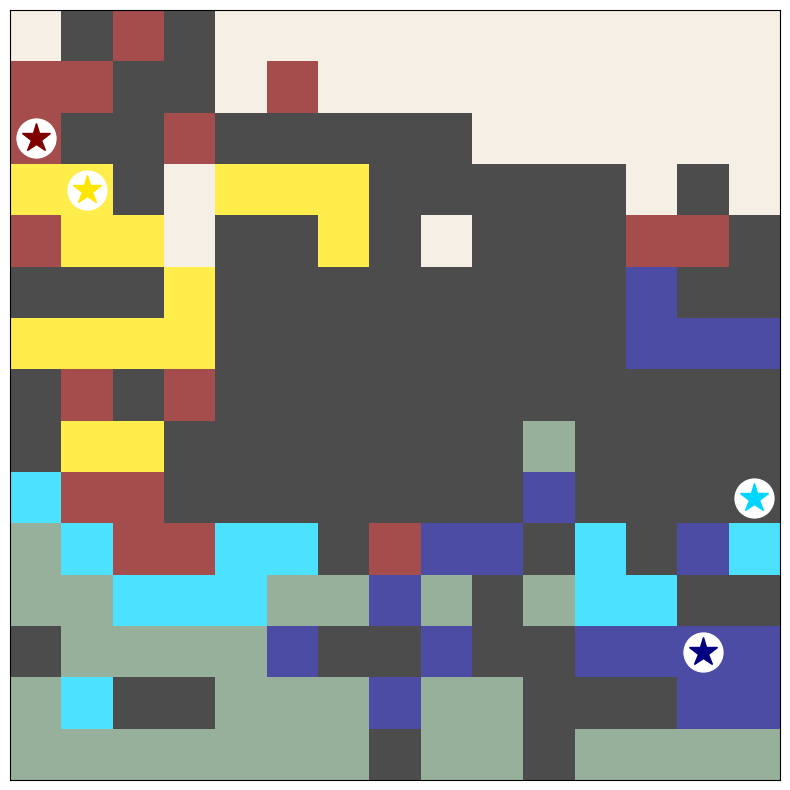

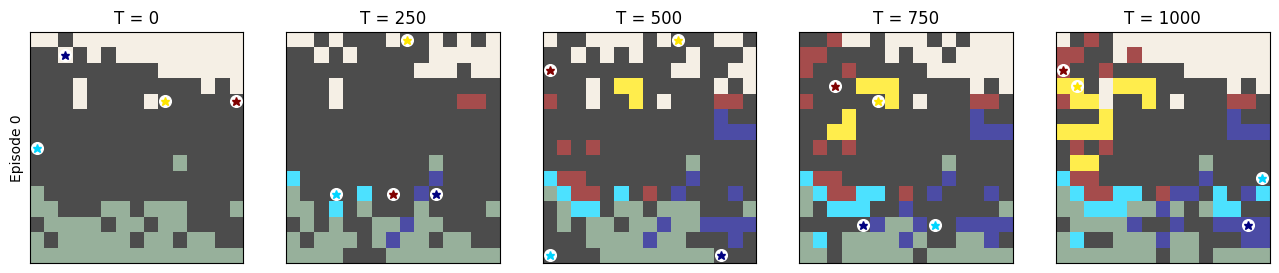

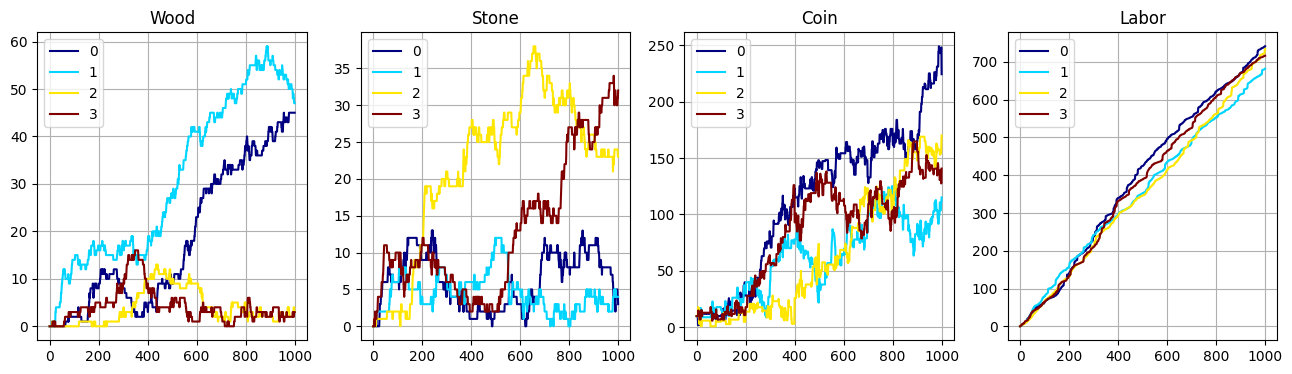

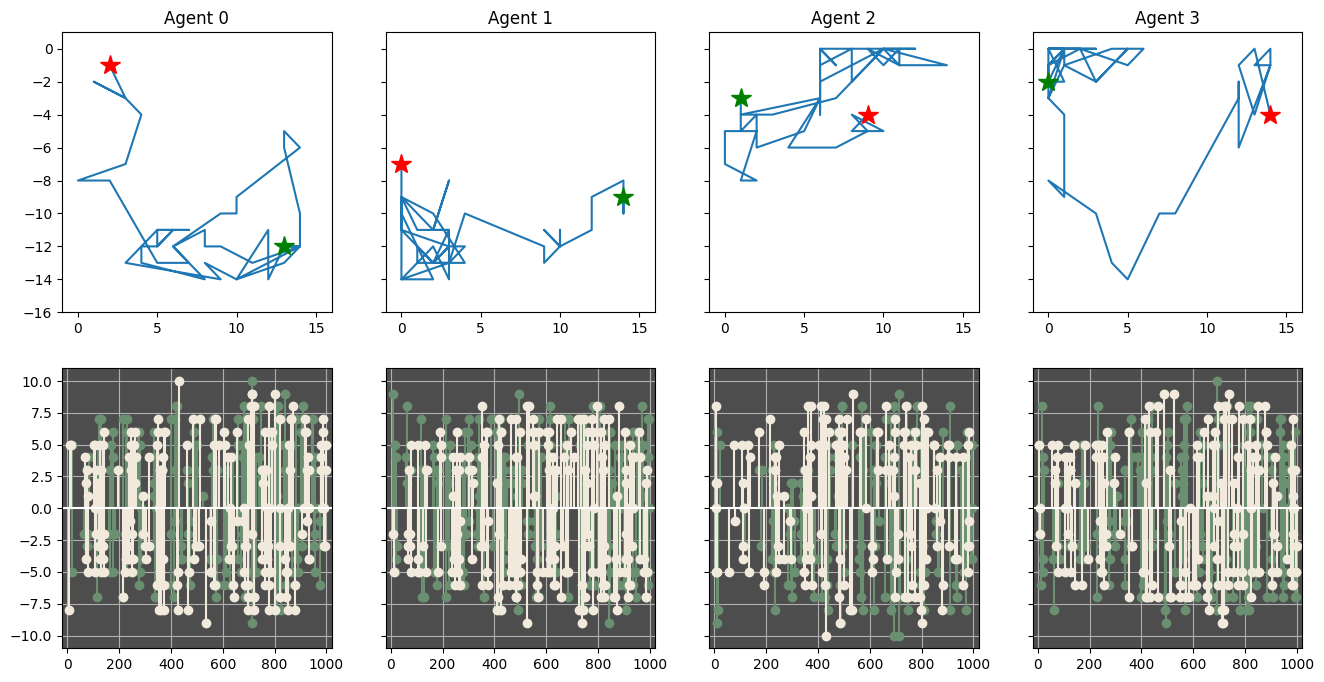

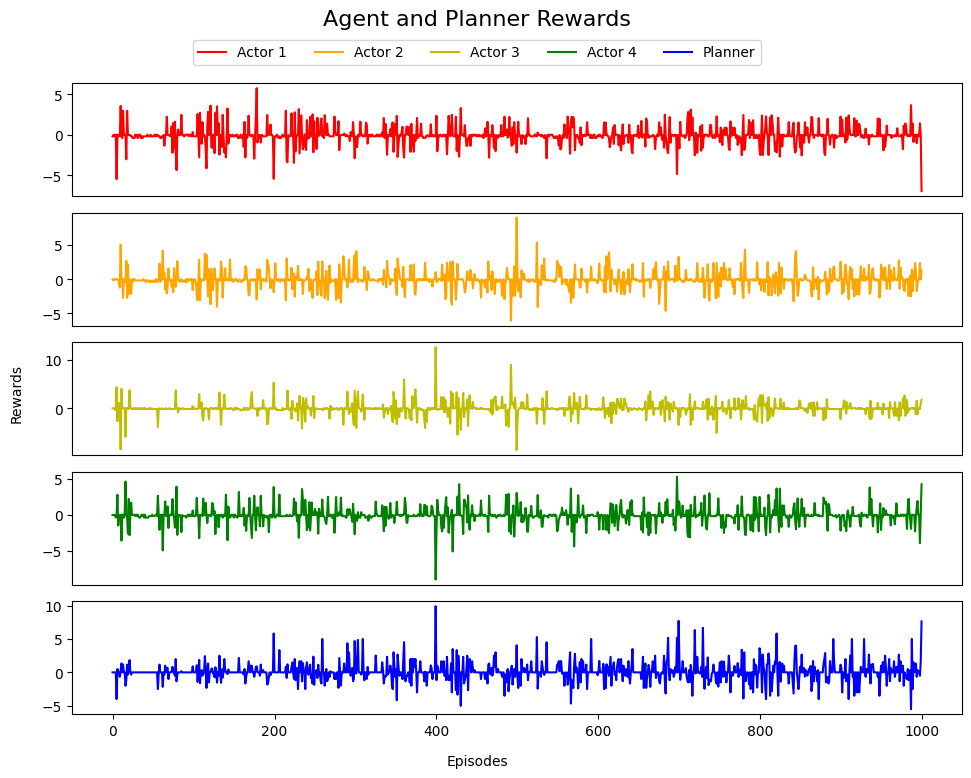

In [189]:
rewards_0 = np.array([], dtype=np.float32)
rewards_1 = np.array([], dtype=np.float32)
rewards_2 = np.array([], dtype=np.float32)
rewards_3= np.array([], dtype=np.float32)
rewards_p = np.array([], dtype=np.float32)
rewards_0, rewards_1, rewards_2, rewards_3, rewards_p = play_random_episode(env1, rewards_0, rewards_1, rewards_2, rewards_3, rewards_p, plot_every=100, do_dense_logging=True)

dense_log = env1.previous_episode_dense_log

(fig0, fig1, fig2), incomes, endows, c_trades, all_builds = plotting.breakdown(dense_log)

fig, axs = plt.figure(figsize=(10, 8)), []
axs.append(plt.subplot(5, 1, 1))
axs[-1].plot(rewards_0, '-r', label="Actor 1")
axs[-1].set_xticks([])
axs.append(plt.subplot(5, 1, 2))
axs[-1].plot(rewards_1, color='orange', label="Actor 2")
axs[-1].set_xticks([])
axs.append(plt.subplot(5, 1, 3))
axs[-1].plot(rewards_2, '-y', label="Actor 3")
axs[-1].set_xticks([])
axs.append(plt.subplot(5, 1, 4))
axs[-1].plot(rewards_3, '-g', label="Actor 4")
axs[-1].set_xticks([])
axs.append(plt.subplot(5, 1, 5))
axs[-1].plot(rewards_p, '-b', label="Planner")

lines = [ax.get_lines()[0] for ax in axs]
labels = [line.get_label() for line in lines]

fig.legend(lines, labels, loc='upper center', ncol=5, bbox_to_anchor=(0.5, 0.95), fontsize=10)
fig.suptitle('Agent and Planner Rewards', fontsize=16)
fig.text(0.5, 0.04, 'Episodes', ha='center', va='center')
fig.text(0.04, 0.5, 'Rewards', ha='center', va='center', rotation='vertical')
plt.tight_layout(rect=[0.05, 0.05, 1, 0.95])
plt.savefig("Plots/env1_rewards.png")
fig1.savefig("Plots/env1_items.png")
plt.show()

## inv_income_weighted_coin_endowments Environment Test

_______________:_ Agent  0 _____|_ Agent  1 _____|_ Agent  2 _____|_ Agent  3 ____
Cost (Wood)    :   4.74 (n= 77) |   5.15 (n= 80) |   4.96 (n= 75) |   4.68 (n= 96)
Cost (Stone)   :   5.18 (n= 67) |   5.18 (n= 73) |   5.33 (n= 83) |   4.77 (n= 52)

Income (Wood)  :   4.60 (n= 86) |   4.82 (n= 89) |   5.06 (n= 72) |   5.05 (n= 81)
Income (Stone) :   5.28 (n= 67) |   5.35 (n= 60) |   5.26 (n= 77) |   4.72 (n= 71)
Income (Build) :  10.00 (n= 14) |  10.00 (n= 11) |  10.00 (n= 15) |  10.00 (n= 21)


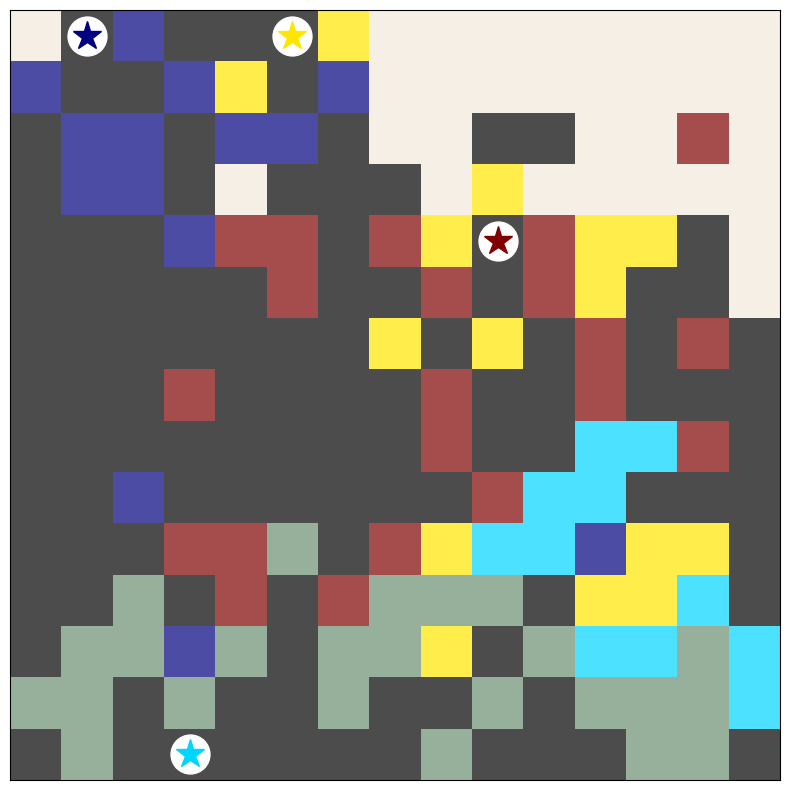

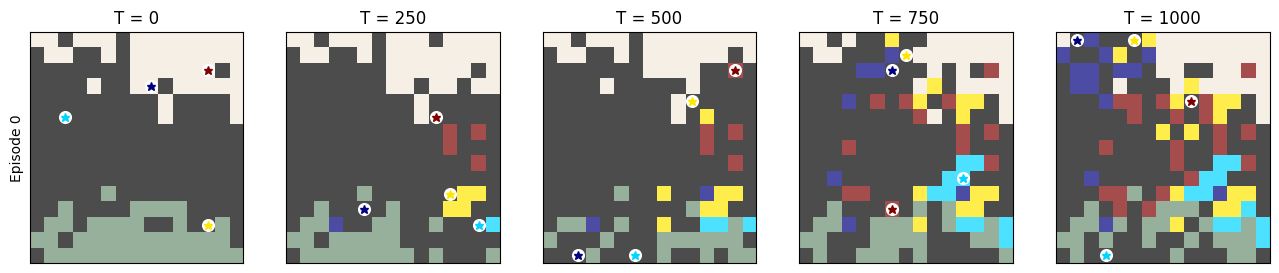

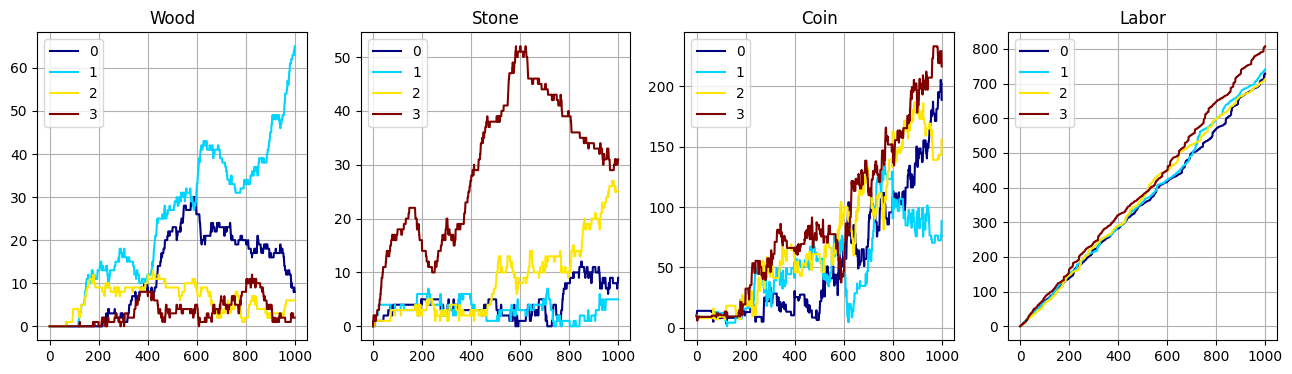

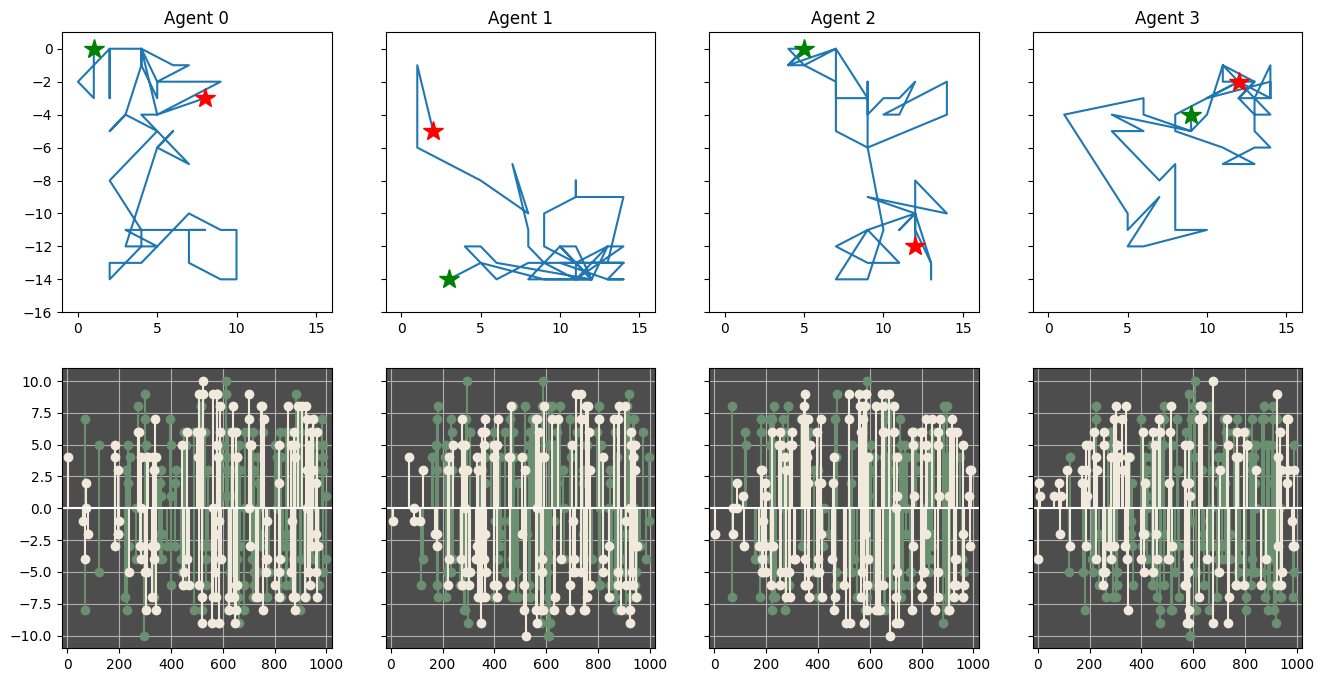

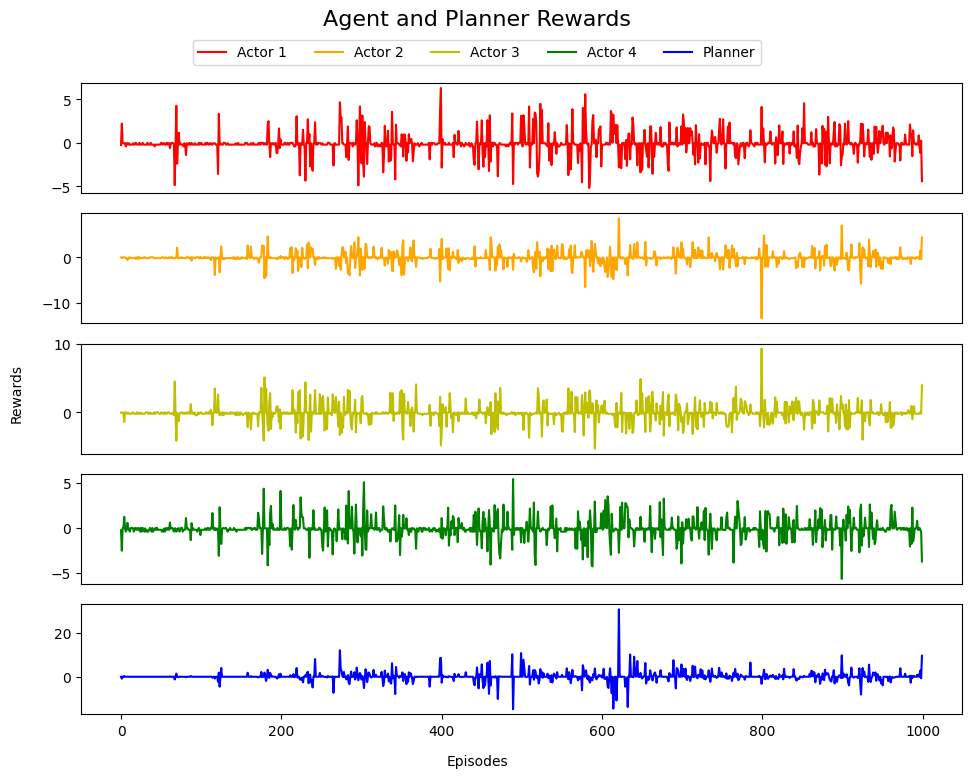

In [190]:
rewards_0 = np.array([], dtype=np.float32)
rewards_1 = np.array([], dtype=np.float32)
rewards_2 = np.array([], dtype=np.float32)
rewards_3= np.array([], dtype=np.float32)
rewards_p = np.array([], dtype=np.float32)
rewards_0, rewards_1, rewards_2, rewards_3, rewards_p = play_random_episode(env2, rewards_0, rewards_1, rewards_2, rewards_3, rewards_p, plot_every=100, do_dense_logging=True)

dense_log = env2.previous_episode_dense_log

(fig0, fig1, fig2), incomes, endows, c_trades, all_builds = plotting.breakdown(dense_log)

fig, axs = plt.figure(figsize=(10, 8)), []
axs.append(plt.subplot(5, 1, 1))
axs[-1].plot(rewards_0, '-r', label="Actor 1")
axs[-1].set_xticks([])
axs.append(plt.subplot(5, 1, 2))
axs[-1].plot(rewards_1, color='orange', label="Actor 2")
axs[-1].set_xticks([])
axs.append(plt.subplot(5, 1, 3))
axs[-1].plot(rewards_2, '-y', label="Actor 3")
axs[-1].set_xticks([])
axs.append(plt.subplot(5, 1, 4))
axs[-1].plot(rewards_3, '-g', label="Actor 4")
axs[-1].set_xticks([])
axs.append(plt.subplot(5, 1, 5))
axs[-1].plot(rewards_p, '-b', label="Planner")

lines = [ax.get_lines()[0] for ax in axs]
labels = [line.get_label() for line in lines]

fig.legend(lines, labels, loc='upper center', ncol=5, bbox_to_anchor=(0.5, 0.95), fontsize=10)
fig.suptitle('Agent and Planner Rewards', fontsize=16)
fig.text(0.5, 0.04, 'Episodes', ha='center', va='center')
fig.text(0.04, 0.5, 'Rewards', ha='center', va='center', rotation='vertical')
plt.tight_layout(rect=[0.05, 0.05, 1, 0.95])
plt.savefig("Plots/env2_rewards.png")
fig1.savefig("Plots/env2_items.png")
plt.show()

## inv_income_weighted_utility Environment Test

_______________:_ Agent  0 _____|_ Agent  1 _____|_ Agent  2 _____|_ Agent  3 ____
Cost (Wood)    :   5.77 (n= 61) |   5.01 (n= 71) |   5.96 (n= 72) |   5.06 (n= 71)
Cost (Stone)   :   5.45 (n= 82) |   5.31 (n= 72) |   5.15 (n= 78) |   5.17 (n= 78)

Income (Wood)  :   5.11 (n= 87) |   5.62 (n= 65) |   5.32 (n= 68) |   5.89 (n= 55)
Income (Stone) :   5.42 (n= 66) |   5.04 (n= 90) |   5.09 (n= 64) |   5.51 (n= 90)
Income (Build) :  10.00 (n= 14) |  10.00 (n=  6) |  10.00 (n= 22) |  10.00 (n= 19)


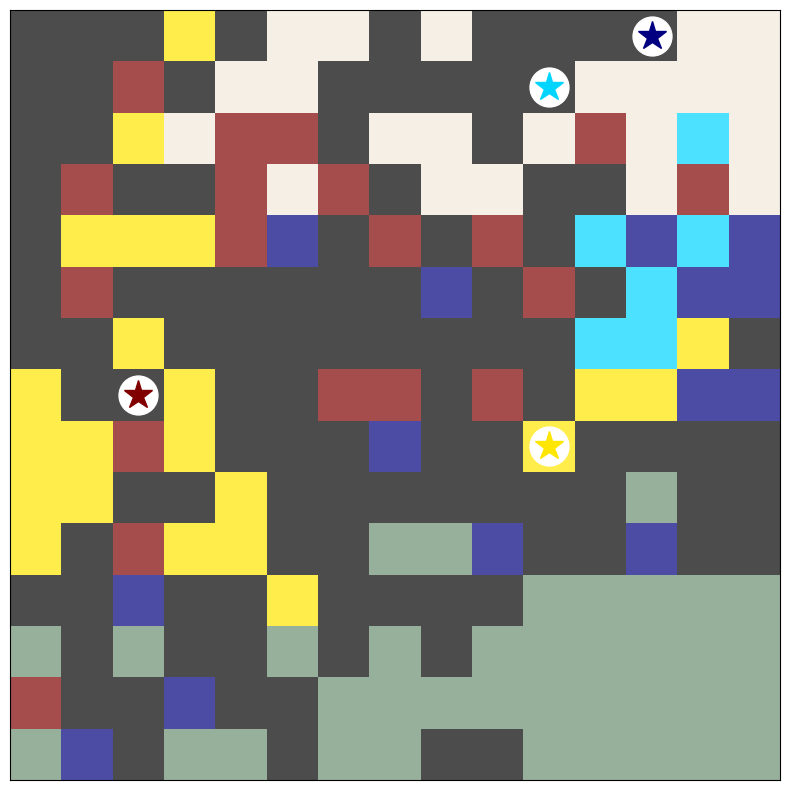

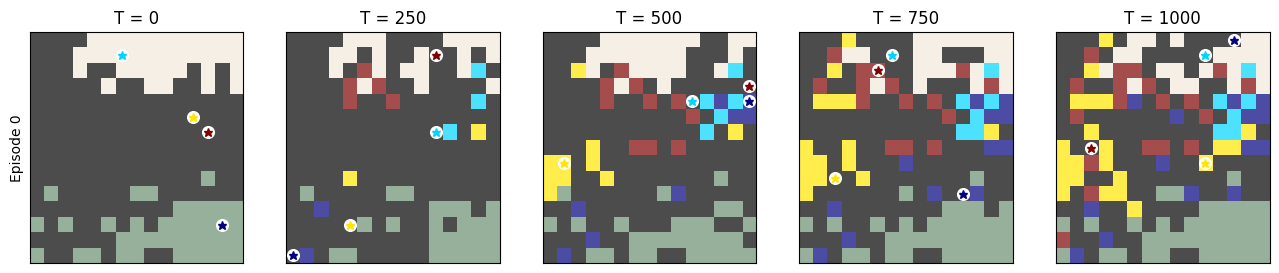

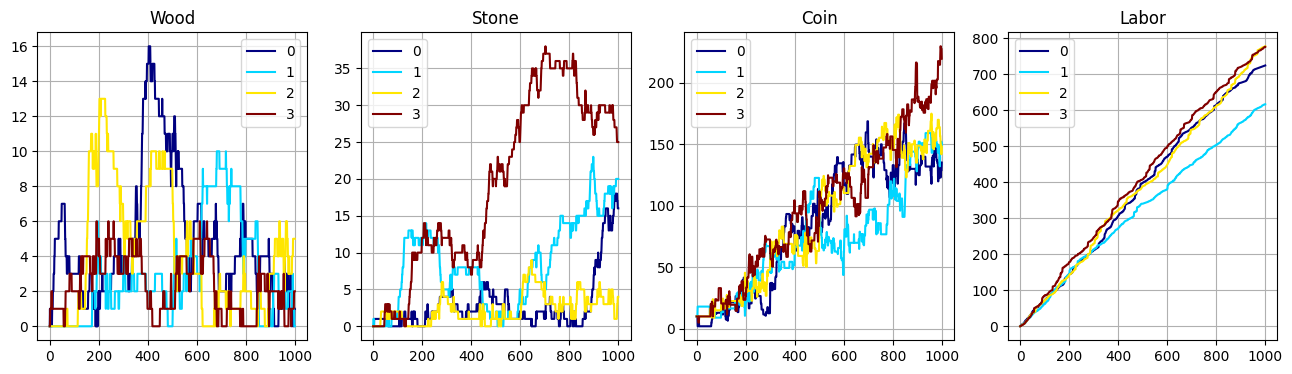

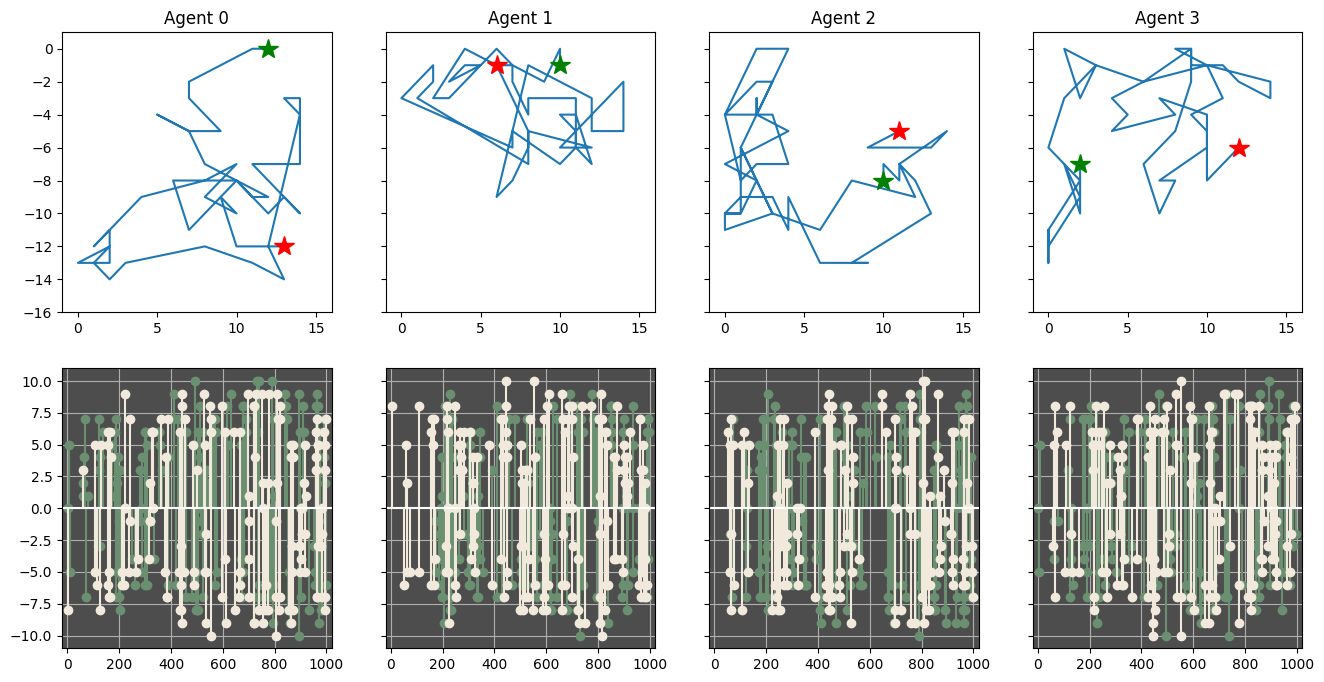

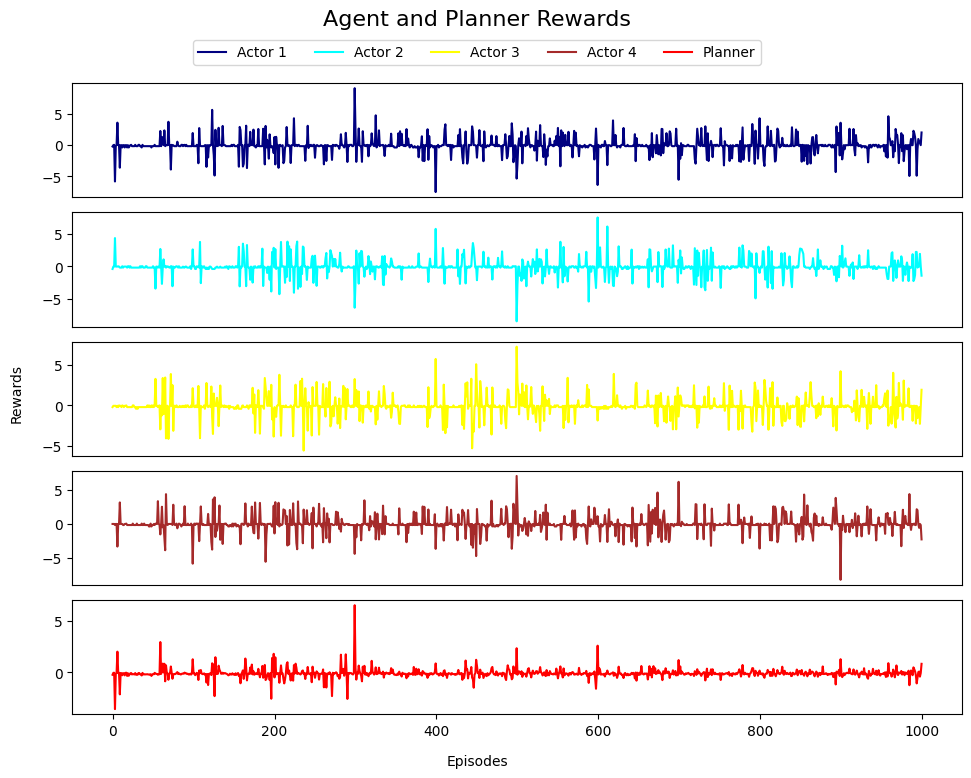

In [193]:
rewards_0 = np.array([], dtype=np.float32)
rewards_1 = np.array([], dtype=np.float32)
rewards_2 = np.array([], dtype=np.float32)
rewards_3= np.array([], dtype=np.float32)
rewards_p = np.array([], dtype=np.float32)
rewards_0, rewards_1, rewards_2, rewards_3, rewards_p = play_random_episode(env3, rewards_0, rewards_1, rewards_2, rewards_3, rewards_p, plot_every=100, do_dense_logging=True)

dense_log = env3.previous_episode_dense_log

(fig0, fig1, fig2), incomes, endows, c_trades, all_builds = plotting.breakdown(dense_log)

fig, axs = plt.figure(figsize=(10, 8)), []
axs.append(plt.subplot(5, 1, 1))
axs[-1].plot(rewards_0, color='navy', label="Actor 1")
axs[-1].set_xticks([])
axs.append(plt.subplot(5, 1, 2))
axs[-1].plot(rewards_1, color='cyan', label="Actor 2")
axs[-1].set_xticks([])
axs.append(plt.subplot(5, 1, 3))
axs[-1].plot(rewards_2, color='yellow', label="Actor 3")
axs[-1].set_xticks([])
axs.append(plt.subplot(5, 1, 4))
axs[-1].plot(rewards_3, color='brown', label="Actor 4")
axs[-1].set_xticks([])
axs.append(plt.subplot(5, 1, 5))
axs[-1].plot(rewards_p, color='red', label="Planner")

lines = [ax.get_lines()[0] for ax in axs]
labels = [line.get_label() for line in lines]

fig.legend(lines, labels, loc='upper center', ncol=5, bbox_to_anchor=(0.5, 0.95), fontsize=10)
fig.suptitle('Agent and Planner Rewards', fontsize=16)
fig.text(0.5, 0.04, 'Episodes', ha='center', va='center')
fig.text(0.04, 0.5, 'Rewards', ha='center', va='center', rotation='vertical')
plt.tight_layout(rect=[0.05, 0.05, 1, 0.95])
plt.savefig("Plots/env3_rewards.png")
fig1.savefig("Plots/env3_items.png")
plt.show()